# Notebook to preprocess Parquets to CSVs (Apr 29, 2025)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import statistics
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as pio

sys.path.append('./')
pd.set_option('display.max_columns', None)
pio.templates.default = "plotly_white+presentation"
pd.options.plotting.backend = 'plotly'
import seaborn as sns

sns.set_theme(context='talk', style='whitegrid', palette='pastel', font_scale=1)

In [ ]:
parq_path = Path('./DB/parquets')

In [ ]:
sessions_df = (
    pd.read_parquet(parq_path / 'instagram_sessions.parquet')
)
sessions_df

,unit_id,media_id,has_image,owner_user_name,owner_comment,session_posted_at,session_likes,number_of_bully_annotations,number_of_aggression_annotations
0,652903355,579610853671398988,True,fazetemperrr,_Ã_Ã,2013-11-01 14:10:19,1378,5,5
1,679604892,686307969342583990,False,fazeclan,"The team with @tejbz! #RedMilitia""",2014-03-28 19:18:27,5337,2,2
2,679604284,609624401625257897,False,paigehathaway,"New Instagram Update""",2013-12-13 00:01:53,16341,4,4
3,679604285,706861199037714379,False,harrysmileforme,"Sometimes I just cry because Harry Styles""",2014-04-26 03:54:03,21623,4,4
4,679604286,708971995763651142,False,playmatekhloeterae,LEFT or RIGHT?,2014-04-29 01:47:49,4602,2,4
...,...,...,...,...,...,...,...,...,...
1554,702714713,534300366003511942,True,channingtatum,A little flash back to the DC leg of the @WHD ...,2013-08-31 01:46:28,114638,0,3
1555,702714715,605977187387338340,True,bajancanadian,Touched down in Montreal - ready to get on tha...,2013-12-07 23:15:31,23223,2,2
1556,702714716,694385747578472711,True,carlafacciolo,My sons on his second bowl of my broccoli rabe...,2014-04-08 22:47:33,1033,0,0
1557,702714717,584259765959916673,True,klarity,"Ladies & Gentlemen.. Introducing.. ""DEM_DIVERS...",2013-11-08 00:06:53,2356,0,0


In [ ]:
comments_df = (
    pd.read_parquet(parq_path / 'instagram_comments.parquet')
    .convert_dtypes()
    .sort_values(['unit_id', 'comment_created_at'])  # sorts the rows so comments appear in temporal order
)
comments_df

,comment_id,unit_id,comment_author,comment_content,comment_created_at
0,61c0f4d1-e0bb-4198-90ae-db52feb917c8,649719575,mightyzulu,Damn bro thats nice,2012-02-13 12:39:58
1,72bd43c8-5b19-4c4f-94dd-eb3cb4a35a3b,649719575,sagadank,Ya I fuck wit dat #R00R,2012-02-13 12:43:00
2,8c7e72fc-45a1-494f-9b44-0a11874716d1,649719575,zburdette,I had one like that #ROORs are the bomb,2012-02-13 12:43:50
3,2b893e63-80a4-433d-9f83-3ee84237eb03,649719575,theworldofme,@treejtv new and it's already got resin buildi...,2012-02-13 12:44:43
4,4a4cf8d6-e441-4bef-b842-5f847ad35070,649719575,tw3bsta,rip that muhh,2012-02-13 12:59:19
...,...,...,...,...,...
106613,f03231ae-3e3c-42be-a3b8-398df997735c,702714718,arcadelaundromat,Omg @deardanagrace,2013-07-13 22:38:20
106614,0c064caf-5dc2-4e1c-80da-e0961f625ded,702714718,z.celine.z,No crocs!....ever!,2013-07-16 18:39:45
106615,0f5af074-9515-4093-8c10-531feeaba444,702714718,infinity_beyond_words,I see those hot guys wearing them all the time,2013-07-25 17:09:39
106616,f261b3cc-e832-4aa5-a558-7d661ae49d67,702714718,alyfeuerborn,Be yourself,2013-08-07 01:12:50


In [ ]:
mturk_comment_annots_df = (
    pd.read_parquet(parq_path / 'mturk_comment_annotations.parquet')
    .fillna('NA')
    .merge(
        comments_df
        [['unit_id', 'comment_id', 'comment_author', 'comment_content', 'comment_created_at']],
        on='comment_id',
    )
    [['unit_id', 'comment_id', 'assignment_id', 'comment_created_at', 'comment_author', 'comment_content',
      'is_cyberbullying', 'bullying_severity', 'bullying_role', 'defense_type']]
    .query('bullying_role!="NA"')
    .astype({'unit_id': int})
    .sort_values(by=['unit_id', 'comment_id'])
)
mturk_comment_annots_df

,unit_id,comment_id,assignment_id,comment_created_at,comment_author,comment_content,is_cyberbullying,bullying_severity,bullying_role,defense_type
5610,649719575,00bde074-639d-46a0-b154-5e9a4b004620,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,passive_bystander,NA
5631,649719575,00bde074-639d-46a0-b154-5e9a4b004620,3HRMW88U1KL7B1CW35U4G1WALLYM00,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,passive_bystander,NA
5652,649719575,00bde074-639d-46a0-b154-5e9a4b004620,3G0WWMR1U9F1HC2VW43J8MCS3FMNQF,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,passive_bystander,NA
5673,649719575,00bde074-639d-46a0-b154-5e9a4b004620,3LEP4MGT3UV5RU9TOSSQHS5Z4HSBDV,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,non_aggressive_defender,support_of_the_victim
5694,649719575,00bde074-639d-46a0-b154-5e9a4b004620,3M0NZ3JDPFT65FXGF0QA5YOA51VZ5F,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,passive_bystander,NA
...,...,...,...,...,...,...,...,...,...,...
110184,702714613,fc5ca5b7-9dfa-4a84-982d-cd360327c7e4,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 22:08:47,hannah_nauertz,it's my birthday too,False,NA,passive_bystander,NA
110308,702714613,fc5ca5b7-9dfa-4a84-982d-cd360327c7e4,3X73LLYYQF9O4J3SDEGPZ8KRQRCNHH,2013-03-24 22:08:47,hannah_nauertz,it's my birthday too,False,NA,passive_bystander,NA
110432,702714613,fc5ca5b7-9dfa-4a84-982d-cd360327c7e4,3UWN2HHPUC0DUSH8O8SO3MRT08FSN6,2013-03-24 22:08:47,hannah_nauertz,it's my birthday too,False,NA,passive_bystander,NA
110556,702714613,fc5ca5b7-9dfa-4a84-982d-cd360327c7e4,3PB5A5BD091L12GUD1HIIBM0CWG7GI,2013-03-24 22:08:47,hannah_nauertz,it's my birthday too,False,NA,passive_bystander,NA


In [ ]:
mturk_assignments = (
    pd.read_parquet(parq_path / 'mturk_assignments.parquet')
)
mturk_assignments

,assignment_id,hit_id,worker_id,unit_id,session_main_victim,worker_submitted_at,worker_accepted_at
0,3FE2ERCCZB3YZL1SX6O7N6MNMQYPOQ,34YWR3PJ3L5FJTD7RARC3ZGEUMXX0I,AURYD2FH3FUOQ,649719897,participants,2024-11-13 08:44:37,2024-11-13 00:24:18
1,3GFK2QRXXNC2BKSB4D636UUS0655WZ,34YWR3PJ3L5FJTD7RARC3ZGEUMXX0I,A1RXG8RE0SJ4LC,649719897,people_in_picture,2024-11-14 13:30:24,2024-11-14 12:52:22
2,3HFNH7HEMV9V7KL990QOI23V0DEGQW,34OWYT6U49C0PSCPSKA4T0US9DNI9F,AURYD2FH3FUOQ,649719895,participants,2024-11-12 08:57:12,2024-11-12 07:32:33
3,3WQ3B2KGEMBBZZTH8Z8VGQ4QD2E1BI,34OWYT6U49C0PSCPSKA4T0US9DNI9F,A2STG331R3P3FK,649719895,participants,2024-11-14 07:10:57,2024-11-13 19:55:05
4,3WMOAN2SRPSTMKYCI3XTE9B0IHDNV3,3SSN80MU9PJHWJKBV31UMJVN8K3KXB,A2EI075XZT9Y2S,649719832,participants,2024-11-12 09:32:31,2024-11-12 07:30:00
...,...,...,...,...,...,...,...
2190,386CSBG1ODHTARW3XNH26BQ6SZ26QX,30Y6N4AHZ2RPLHSPUN9FTOE9OCQRDF,A38DC3BG1ZCVZ2,679605350,people_in_picture,2024-12-07 03:06:35,2024-12-07 02:08:23
2191,3ZR9AIQJUP4R7BNQX1U8U7FAJ1K40S,30Y6N4AHZ2RPLHSPUN9FTOE9OCQRDF,AE861G0AY5RGT,679605350,people_in_picture,2024-12-07 04:17:36,2024-12-07 00:22:45
2192,3I0BTBYZABG75I1AM8IFAWJHEH70YR,30Y6N4AHZ2RPLHSPUN9FTOE9OCQRDF,AZLZA0Q87TJZO,679605350,people_in_picture,2024-12-07 11:37:15,2024-12-07 10:37:34
2193,3QILPRALQJQVB82ZAAMJMVRSUGL8N9,30Y6N4AHZ2RPLHSPUN9FTOE9OCQRDF,A2ELXYKRPPGRPB,679605350,people_in_picture,2024-12-08 05:03:07,2024-12-08 04:16:33


Fix the bug with majority voting.
If cyberbullying_majority, consider majority vote from `is_cyberbullying=True` rows

# <font color=DarkOrange> Decision point: discarding info from annotators in the minority </font>

In [ ]:
filt_mturk_comment_annots_df = (
    mturk_comment_annots_df
    .assign(
        cyberbullying_counts=lambda df_: (
            df_.groupby(['unit_id', 'comment_id'], as_index=False, sort=False)
            .is_cyberbullying
            .transform('sum')
        ),
        is_cyberbullying_majority=lambda df_: (df_.cyberbullying_counts >= 3),
    )
    .query('is_cyberbullying==is_cyberbullying_majority')  # gets rid of rows that disagree
)
filt_mturk_comment_annots_df

,unit_id,comment_id,assignment_id,comment_created_at,comment_author,comment_content,is_cyberbullying,bullying_severity,bullying_role,defense_type,cyberbullying_counts,is_cyberbullying_majority
5610,649719575,00bde074-639d-46a0-b154-5e9a4b004620,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,passive_bystander,NA,0,False
5631,649719575,00bde074-639d-46a0-b154-5e9a4b004620,3HRMW88U1KL7B1CW35U4G1WALLYM00,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,passive_bystander,NA,0,False
5652,649719575,00bde074-639d-46a0-b154-5e9a4b004620,3G0WWMR1U9F1HC2VW43J8MCS3FMNQF,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,passive_bystander,NA,0,False
5673,649719575,00bde074-639d-46a0-b154-5e9a4b004620,3LEP4MGT3UV5RU9TOSSQHS5Z4HSBDV,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,non_aggressive_defender,support_of_the_victim,0,False
5694,649719575,00bde074-639d-46a0-b154-5e9a4b004620,3M0NZ3JDPFT65FXGF0QA5YOA51VZ5F,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,passive_bystander,NA,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
110184,702714613,fc5ca5b7-9dfa-4a84-982d-cd360327c7e4,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 22:08:47,hannah_nauertz,it's my birthday too,False,NA,passive_bystander,NA,0,False
110308,702714613,fc5ca5b7-9dfa-4a84-982d-cd360327c7e4,3X73LLYYQF9O4J3SDEGPZ8KRQRCNHH,2013-03-24 22:08:47,hannah_nauertz,it's my birthday too,False,NA,passive_bystander,NA,0,False
110432,702714613,fc5ca5b7-9dfa-4a84-982d-cd360327c7e4,3UWN2HHPUC0DUSH8O8SO3MRT08FSN6,2013-03-24 22:08:47,hannah_nauertz,it's my birthday too,False,NA,passive_bystander,NA,0,False
110556,702714613,fc5ca5b7-9dfa-4a84-982d-cd360327c7e4,3PB5A5BD091L12GUD1HIIBM0CWG7GI,2013-03-24 22:08:47,hannah_nauertz,it's my birthday too,False,NA,passive_bystander,NA,0,False


In [ ]:
filt_mturk_comment_annots_df

,unit_id,comment_id,assignment_id,comment_created_at,comment_author,comment_content,is_cyberbullying,bullying_severity,bullying_role,defense_type,cyberbullying_counts,is_cyberbullying_majority
5610,649719575,00bde074-639d-46a0-b154-5e9a4b004620,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,passive_bystander,NA,0,False
5631,649719575,00bde074-639d-46a0-b154-5e9a4b004620,3HRMW88U1KL7B1CW35U4G1WALLYM00,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,passive_bystander,NA,0,False
5652,649719575,00bde074-639d-46a0-b154-5e9a4b004620,3G0WWMR1U9F1HC2VW43J8MCS3FMNQF,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,passive_bystander,NA,0,False
5673,649719575,00bde074-639d-46a0-b154-5e9a4b004620,3LEP4MGT3UV5RU9TOSSQHS5Z4HSBDV,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,non_aggressive_defender,support_of_the_victim,0,False
5694,649719575,00bde074-639d-46a0-b154-5e9a4b004620,3M0NZ3JDPFT65FXGF0QA5YOA51VZ5F,2012-02-13 16:11:31,thedangerfield,PASS IT. SMOKE IT.,False,NA,passive_bystander,NA,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
110184,702714613,fc5ca5b7-9dfa-4a84-982d-cd360327c7e4,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 22:08:47,hannah_nauertz,it's my birthday too,False,NA,passive_bystander,NA,0,False
110308,702714613,fc5ca5b7-9dfa-4a84-982d-cd360327c7e4,3X73LLYYQF9O4J3SDEGPZ8KRQRCNHH,2013-03-24 22:08:47,hannah_nauertz,it's my birthday too,False,NA,passive_bystander,NA,0,False
110432,702714613,fc5ca5b7-9dfa-4a84-982d-cd360327c7e4,3UWN2HHPUC0DUSH8O8SO3MRT08FSN6,2013-03-24 22:08:47,hannah_nauertz,it's my birthday too,False,NA,passive_bystander,NA,0,False
110556,702714613,fc5ca5b7-9dfa-4a84-982d-cd360327c7e4,3PB5A5BD091L12GUD1HIIBM0CWG7GI,2013-03-24 22:08:47,hannah_nauertz,it's my birthday too,False,NA,passive_bystander,NA,0,False


In [ ]:
comment_id = '45d5020f-d374-4255-ab24-2294021d5232'
(
    mturk_comment_annots_df
    .query('comment_id==@comment_id')
)

,unit_id,comment_id,assignment_id,comment_created_at,comment_author,comment_content,is_cyberbullying,bullying_severity,bullying_role,defense_type
120199,679604287,45d5020f-d374-4255-ab24-2294021d5232,34S6N1K2Z9EYGJ07110AMGG2R27HLM,2014-05-12 17:25:16,tatobmartin14,@ellie_thomas11 haters gonna hate,False,NA,passive_bystander,NA
120256,679604287,45d5020f-d374-4255-ab24-2294021d5232,32UTUBMZ7URRLB9FFDSKNEB6N8NVBS,2014-05-12 17:25:16,tatobmartin14,@ellie_thomas11 haters gonna hate,False,NA,non_aggressive_defender,direct_to_the_bully
120313,679604287,45d5020f-d374-4255-ab24-2294021d5232,39KFRKBFI1QS8ZTTOTKQ0XFZCTXYO7,2014-05-12 17:25:16,tatobmartin14,@ellie_thomas11 haters gonna hate,True,mild,aggressive_defender,NA
120370,679604287,45d5020f-d374-4255-ab24-2294021d5232,3U8YCDAGX3BYWGAOVY1LXAGFFLIQ0W,2014-05-12 17:25:16,tatobmartin14,@ellie_thomas11 haters gonna hate,False,NA,non_aggressive_victim,NA
120427,679604287,45d5020f-d374-4255-ab24-2294021d5232,3ZGVPD4G67C8QH86GW888EUOIC8ZTA,2014-05-12 17:25:16,tatobmartin14,@ellie_thomas11 haters gonna hate,False,NA,non_aggressive_defender,support_of_the_victim


### only keep those topic assignments where the comment has:
* `majority_cyberbullying=True`, AND
* the annotator also flagged it as `is_cyberbullying=True`

In [ ]:
keep_df = (
    filt_mturk_comment_annots_df
    .query('is_cyberbullying & is_cyberbullying_majority')
)
keep_assign_ids = set(keep_df.assignment_id)
keep_comment_ids = set(keep_df.comment_id)
comment_topics_df = (
    pd.read_parquet(parq_path / 'mturk_comment_topics.parquet')
    .assign(
        topic=lambda df_: df_.topic.str.replace('none', 'other'),
    )
    .sort_values(by=['comment_id', 'assignment_id'])
    .query('assignment_id.isin(@keep_assign_ids) & comment_id.isin(@keep_comment_ids)')
)
comment_topics_df

,comment_id,assignment_id,topic
9044,000353ad-cb98-48da-a37a-91ea8cb576ab,33LK57MYL707BHVRRW3IY9Y2WEJSZP,other
8982,000353ad-cb98-48da-a37a-91ea8cb576ab,345LHZDEDBNM51G2VU3999BB1J83UR,gender
8920,000353ad-cb98-48da-a37a-91ea8cb576ab,34Q075JO1B8AFCQ7AJB6W987NCK01R,social_status
9119,000353ad-cb98-48da-a37a-91ea8cb576ab,3URFVVM16JDNQUNVG1YIDAGQIUWUZ2,other
57232,0003a565-d199-4c87-98a2-b0d6ff6c062f,3D4CH1LGEOOPFL4NSYF2W7D67PL9GJ,sexual
...,...,...,...
51935,fff536df-83f0-41d7-abbc-656dd76faa26,31T4R4OBO6B8KQ0PBFLZSK1LGKJC76,other
51844,fff536df-83f0-41d7-abbc-656dd76faa26,379J5II412BMW995B0S41DJPVOBLE6,other
51763,fff536df-83f0-41d7-abbc-656dd76faa26,3MMN5BL1WDZ3STBTMSCNIZUH3LMM3Q,intellectual
51764,fff536df-83f0-41d7-abbc-656dd76faa26,3MMN5BL1WDZ3STBTMSCNIZUH3LMM3Q,social_status


In [ ]:
comment_topics_wide_df = (
    pd.pivot_table(
        comment_topics_df,
        index='comment_id',
        columns='topic',
        aggfunc='count',
        values='assignment_id',
        fill_value=0,
    )
    .rename(columns=lambda c: c + '_topic_votes')
)

comment_topics_wide_df

topic,disability_topic_votes,gender_topic_votes,intellectual_topic_votes,other_topic_votes,physical_topic_votes,political_topic_votes,race_topic_votes,religious_topic_votes,sexual_topic_votes,social_status_topic_votes
comment_id,,,,,,,,,,
000353ad-cb98-48da-a37a-91ea8cb576ab,0,1,0,2,0,0,0,0,0,1
0003a565-d199-4c87-98a2-b0d6ff6c062f,0,0,0,2,0,0,0,0,1,0
000473ca-3f9c-4f67-9df6-a40bdfc2e2a0,0,2,0,2,1,0,0,0,0,0
00061bbf-6d95-4d26-8859-4fe797553777,0,0,0,2,3,0,0,0,2,0
001aabbd-a104-49ae-8979-efe9ec5256fb,0,0,0,3,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
ffcf7464-c121-43d0-aaf4-dbf2ab927c9b,0,2,2,1,0,0,0,0,0,1
ffd00c60-20cf-4841-9a77-c40b0e934da5,0,2,2,0,0,0,0,0,3,2
ffddd759-6342-48fa-aaba-92be9d4c87df,0,0,0,4,0,0,0,0,0,0


In [ ]:
# fix majority voting
filt_mturk_comment_annots_topic_df = (
    filt_mturk_comment_annots_df
    .merge(
        comment_topics_wide_df,
        left_on='comment_id',
        right_index=True,
        how='left',
    )
    .sort_values(['unit_id', 'comment_created_at'])
    .fillna({c: 0 for c in comment_topics_wide_df.columns})
    .astype({c: int for c in comment_topics_wide_df.columns})
)
filt_mturk_comment_annots_topic_df

,unit_id,comment_id,assignment_id,comment_created_at,comment_author,comment_content,is_cyberbullying,bullying_severity,bullying_role,defense_type,cyberbullying_counts,is_cyberbullying_majority,disability_topic_votes,gender_topic_votes,intellectual_topic_votes,other_topic_votes,physical_topic_votes,political_topic_votes,race_topic_votes,religious_topic_votes,sexual_topic_votes,social_status_topic_votes
5620,649719575,61c0f4d1-e0bb-4198-90ae-db52feb917c8,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-02-13 12:39:58,mightyzulu,Damn bro thats nice,False,NA,passive_bystander,NA,0,False,0,0,0,0,0,0,0,0,0,0
5641,649719575,61c0f4d1-e0bb-4198-90ae-db52feb917c8,3HRMW88U1KL7B1CW35U4G1WALLYM00,2012-02-13 12:39:58,mightyzulu,Damn bro thats nice,False,NA,passive_bystander,NA,0,False,0,0,0,0,0,0,0,0,0,0
5662,649719575,61c0f4d1-e0bb-4198-90ae-db52feb917c8,3G0WWMR1U9F1HC2VW43J8MCS3FMNQF,2012-02-13 12:39:58,mightyzulu,Damn bro thats nice,False,NA,passive_bystander,NA,0,False,0,0,0,0,0,0,0,0,0,0
5683,649719575,61c0f4d1-e0bb-4198-90ae-db52feb917c8,3LEP4MGT3UV5RU9TOSSQHS5Z4HSBDV,2012-02-13 12:39:58,mightyzulu,Damn bro thats nice,False,NA,non_aggressive_defender,support_of_the_victim,0,False,0,0,0,0,0,0,0,0,0,0
5704,649719575,61c0f4d1-e0bb-4198-90ae-db52feb917c8,3M0NZ3JDPFT65FXGF0QA5YOA51VZ5F,2012-02-13 12:39:58,mightyzulu,Damn bro thats nice,False,NA,passive_bystander,NA,0,False,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110637,702714613,9aec0871-3b47-4d24-a776-d48357f729e4,3D4CH1LGEOOPFL4NSYF2W7D67PL9GJ,2013-11-02 20:00:23,sarahshipley2004,Just so u know I have the same last name as u,False,NA,passive_bystander,NA,0,False,0,0,0,0,0,0,0,0,0,0
110204,702714613,1d2e1d0c-47a3-4354-bb86-3483f64e97e0,3X73LLYYQF9O4J3SDEGPZ8KRQRCNHH,2014-04-05 19:18:10,1211_r1a_1211,@drew_shipley u look uncomfortable,False,NA,passive_bystander,NA,1,False,0,0,0,0,0,0,0,0,0,0
110328,702714613,1d2e1d0c-47a3-4354-bb86-3483f64e97e0,3UWN2HHPUC0DUSH8O8SO3MRT08FSN6,2014-04-05 19:18:10,1211_r1a_1211,@drew_shipley u look uncomfortable,False,NA,passive_bystander,NA,1,False,0,0,0,0,0,0,0,0,0,0
110452,702714613,1d2e1d0c-47a3-4354-bb86-3483f64e97e0,3PB5A5BD091L12GUD1HIIBM0CWG7GI,2014-04-05 19:18:10,1211_r1a_1211,@drew_shipley u look uncomfortable,False,NA,passive_bystander,NA,1,False,0,0,0,0,0,0,0,0,0,0


In [ ]:
## keep only rows where `is_cyberbullying_majority` agrees with `is_cyberbullying`
filt_agg_mturk_comment_annots_df = (
    filt_mturk_comment_annots_topic_df
    .groupby(['unit_id', 'comment_id'], as_index=False, sort=False)
    .agg(
        assignment_id=('assignment_id', 'first'),
        comment_created_at=('comment_created_at', 'first'),
        comment_author=('comment_author', 'first'),
        comment_content=('comment_content', 'first'),
        is_cyberbullying_majority=('is_cyberbullying_majority', 'first'),

        bullying_severities=('bullying_severity', list),
        defense_types=('defense_type', list),
        bullying_roles=('bullying_role', list),
    )
    .merge(
        comment_topics_wide_df,
        left_on='comment_id',
        right_index=True,
        how='left',
    )
    .sort_values(['unit_id'])
    .fillna({c: 0 for c in comment_topics_wide_df.columns})
    .astype({c: int for c in comment_topics_wide_df.columns})
    .merge(
        sessions_df
        [['unit_id', 'owner_user_name', 'owner_comment']],
        on='unit_id',
        how='left',
    )
    .astype({'unit_id': int})
)
filt_agg_mturk_comment_annots_df

,unit_id,comment_id,assignment_id,comment_created_at,comment_author,comment_content,is_cyberbullying_majority,bullying_severities,defense_types,bullying_roles,disability_topic_votes,gender_topic_votes,intellectual_topic_votes,other_topic_votes,physical_topic_votes,political_topic_votes,race_topic_votes,religious_topic_votes,sexual_topic_votes,social_status_topic_votes,owner_user_name,owner_comment
0,649719575,61c0f4d1-e0bb-4198-90ae-db52feb917c8,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-02-13 12:39:58,mightyzulu,Damn bro thats nice,False,"[NA, NA, NA, NA, NA]","[NA, NA, NA, support_of_the_victim, NA]","[passive_bystander, passive_bystander, passive...",0,0,0,0,0,0,0,0,0,0,treejtv,new bong mac got me
1,649719575,8b18052e-5ea1-47d9-86be-4409c483d47d,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-05-07 00:18:06,allisonkoch,I have that!!!! Haha<3,False,"[NA, NA, NA, NA, NA]","[NA, NA, NA, support_of_the_victim, NA]","[passive_bystander, passive_bystander, passive...",0,0,0,0,0,0,0,0,0,0,treejtv,new bong mac got me
2,649719575,ed7714a6-7391-4a14-81f7-3a16873012aa,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-04-08 19:26:56,kushjon,Roors don't suck u do lol,True,"[mild, mild, moderate, mild]","[NA, NA, NA, NA]","[aggressive_defender, bully, aggressive_defend...",0,0,0,2,0,0,0,0,0,2,treejtv,new bong mac got me
3,649719575,3289fd82-01fd-479e-807d-82c6cf944e1d,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-03-13 06:37:19,mikesdope,E and my nigga tree jay fuck with thy dank weed,False,"[NA, NA, NA, NA, NA]","[NA, NA, NA, support_of_the_victim, NA]","[passive_bystander, passive_bystander, passive...",0,0,0,0,0,0,0,0,0,0,treejtv,new bong mac got me
4,649719575,347d5efe-90eb-47cb-87d6-9912ed8c9b54,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-03-03 18:03:13,haaaaaarvey,ahah sick got the same one with blue writing!,False,"[NA, NA, NA, NA, NA]","[NA, NA, NA, support_of_the_victim, NA]","[passive_bystander, passive_bystander, passive...",0,0,0,0,0,0,0,0,0,0,treejtv,new bong mac got me
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35359,702714613,f0047335-4e85-4b13-98e9-ecb0ff029ae9,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 21:45:06,eceminem,"If you ever wanted to kill yourself, read my n...",False,"[NA, NA, NA, NA]","[NA, NA, NA, NA]","[passive_bystander, passive_bystander, passive...",0,0,0,0,0,0,0,0,0,0,drew_shipley,"Happy birthday @kellymerring_Ù_ö_Ù__Ù_ä"""
35360,702714613,d4d8e9fa-49ef-414c-9e43-fadd2fd4e844,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 21:43:08,fightclubcaptain,thx! @peaceloveuniquegirl123,False,"[NA, NA, NA, NA, NA]","[NA, NA, NA, NA, NA]","[non_aggressive_victim, passive_bystander, pas...",0,0,0,0,0,0,0,0,0,0,drew_shipley,"Happy birthday @kellymerring_Ù_ö_Ù__Ù_ä"""
35361,702714613,5e037eef-04f7-4f76-975c-958973524e6f,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 21:41:16,its_gaoyinggg98,Happy birthday @hhhaaannaaahhh!!! :),False,"[NA, NA, NA, NA, NA]","[NA, NA, NA, NA, NA]","[passive_bystander, passive_bystander, passive...",0,0,0,0,0,0,0,0,0,0,drew_shipley,"Happy birthday @kellymerring_Ù_ö_Ù__Ù_ä"""
35362,702714613,a07e7cde-f2ab-475f-957d-adaca46e2b88,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 22:04:52,cathy_truong,@chelsea_200 you're* and i want to speak up be...,False,"[NA, NA, NA, NA, NA]","[direct_to_the_bully, direct_to_the_bully, dir...","[non_aggressive_defender, non_aggressive_defen...",0,0,0,0,0,0,0,0,0,0,drew_shipley,"Happy birthday @kellymerring_Ù_ö_Ù__Ù_ä"""


## create `session_info.csv`

In [ ]:
session_nodes_df = (
    filt_agg_mturk_comment_annots_df
    .groupby('unit_id', sort=False, as_index=False)
    .agg(
        owner_user_name=('owner_user_name', 'first'),
        owner_comment=('owner_comment', 'first'),
        num_comments=('comment_id', 'nunique'),
    )
    .merge(
        sessions_df
        [['unit_id', 'media_id', 'session_posted_at', 'session_likes']],
        on='unit_id', how='left'
    )
    .merge(
        mturk_assignments
        .groupby('unit_id', sort=False, as_index=False)
        .agg(
            session_main_victims=('session_main_victim', list),
        )
        .assign(
            most_freq_main_victim=lambda df_: df_.session_main_victims.apply(
                lambda l: set(set(statistics.multimode(l)))
            ),
        )
        .assign(
            most_freq_main_victim=lambda df_: df_.most_freq_main_victim.apply(lambda f: '|'.join(sorted(f))),
        )
        .drop(columns=['session_main_victims']),
        on='unit_id', how='left',
    )
    .rename(columns={'unit_id': 'session_id', 'session_posted_at': 'timestamp', 'session_likes': 'num_likes'})
    [['session_id', 'timestamp', 'owner_user_name', 'owner_comment', 'media_id', 'num_likes', 'num_comments',
      'most_freq_main_victim']]
    .sort_values(by='timestamp', ascending=True)
)
display(session_nodes_df)

(
    session_nodes_df
    .to_csv('./outputs/sessions_info_v2.csv', index=False)
)

,session_id,timestamp,owner_user_name,owner_comment,media_id,num_likes,num_comments,most_freq_main_victim
255,652903523,2012-02-01 08:31:16,larryfisherman,This is my director @rexarrowfilms,650555021,3051,116,participants
0,649719575,2012-02-13 12:38:58,treejtv,new bong mac got me,125130489044291535,570,21,user
1,649719576,2012-02-28 00:45:13,danielrochatat2,So I find out that I am missing some of my Fus...,135642885730926248,44,22,other|user
2,649719577,2012-03-11 16:17:22,chelseahouska,Beautiful <3,144809356454375342,1381,67,participants|user
376,679604932,2012-03-29 21:25:22,kinggoldchains,"#LastKings""",158010340606077834,12316,130,participants
...,...,...,...,...,...,...,...,...
287,652910786,NaT,kinggoldchains,None,713258777732311868,46275,141,people_in_picture
291,652910810,NaT,wtffact,Double tap and follow -> @jjones2fi,720377560597610011,485,38,participants|user
296,652910833,NaT,catdagreat,P H E N O M E N A,730436892557966858,1770,48,people_in_picture
297,652910837,NaT,justinbieberfans,ADORABLE_Ã´ÃÂ_Ã´ÃÃ_Ã´Ãâ _Ã´Ã__Ã´ÃÂ´_Ã´Ã,731726217478301176,2577,93,people_in_picture


In [ ]:
statistics.multimode(['NA', 'NA', 'a', 'a'])

['NA', 'a']

In [ ]:
def agg_defense_type(row):
    # print(row, type(row))
    role = list(row.most_freq_bullying_role)[0]
    if role == 'non_aggressive_defender':
        row.defense_types = [d for d in row.defense_types if d != 'NA']
    # print('---')
    # print(row)
    return set(statistics.multimode(row.defense_types))

In [ ]:
filt_agg_mturk_comment_annots_df.bullying_roles.values[0]

list

In [ ]:
comment_nodes_df = (
    filt_agg_mturk_comment_annots_df
    .assign(
        most_freq_bullying_role=lambda df_: df_.bullying_roles.apply(lambda l: set(statistics.multimode(l))),
        most_freq_bullying_severity=lambda df_: df_.bullying_severities.apply(lambda l: set(statistics.multimode(l))),
        most_freq_defense_type=lambda df_: df_.apply(lambda row: agg_defense_type(row), axis=1),
        # most_freq_topic=lambda df_: df_.topics.apply(lambda l: set(statistics.multimode(l))),
    )
    .drop(columns=['bullying_roles', 'defense_types', 'bullying_severities', 'owner_user_name', 'owner_comment',
                   'unit_id'])
    .rename(
        columns={'cyberbullying_counts': 'num_cyberbullying_tags',  #'is_cyberbullying': 'is_cyberbullying_majority',
                 'comment_created_at': 'comment_timestamp'})
    # [['comment_id', 'comment_author', 'comment_timestamp', 'comment_content', 'num_cyberbullying_tags',
    #   'is_cyberbullying_majority',
    #   'most_freq_bullying_role', 'most_freq_bullying_severity', 'most_freq_defense_type',
    #   # 'most_freq_topic'
    #  ]]
)
comment_nodes_df

,comment_id,assignment_id,comment_timestamp,comment_author,comment_content,is_cyberbullying_majority,disability_topic_votes,gender_topic_votes,intellectual_topic_votes,other_topic_votes,physical_topic_votes,political_topic_votes,race_topic_votes,religious_topic_votes,sexual_topic_votes,social_status_topic_votes,most_freq_bullying_role,most_freq_bullying_severity,most_freq_defense_type
0,61c0f4d1-e0bb-4198-90ae-db52feb917c8,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-02-13 12:39:58,mightyzulu,Damn bro thats nice,False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
1,8b18052e-5ea1-47d9-86be-4409c483d47d,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-05-07 00:18:06,allisonkoch,I have that!!!! Haha<3,False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
2,ed7714a6-7391-4a14-81f7-3a16873012aa,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-04-08 19:26:56,kushjon,Roors don't suck u do lol,True,0,0,0,2,0,0,0,0,0,2,"{bully, aggressive_defender}",{mild},{NA}
3,3289fd82-01fd-479e-807d-82c6cf944e1d,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-03-13 06:37:19,mikesdope,E and my nigga tree jay fuck with thy dank weed,False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
4,347d5efe-90eb-47cb-87d6-9912ed8c9b54,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-03-03 18:03:13,haaaaaarvey,ahah sick got the same one with blue writing!,False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35359,f0047335-4e85-4b13-98e9-ecb0ff029ae9,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 21:45:06,eceminem,"If you ever wanted to kill yourself, read my n...",False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
35360,d4d8e9fa-49ef-414c-9e43-fadd2fd4e844,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 21:43:08,fightclubcaptain,thx! @peaceloveuniquegirl123,False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
35361,5e037eef-04f7-4f76-975c-958973524e6f,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 21:41:16,its_gaoyinggg98,Happy birthday @hhhaaannaaahhh!!! :),False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
35362,a07e7cde-f2ab-475f-957d-adaca46e2b88,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 22:04:52,cathy_truong,@chelsea_200 you're* and i want to speak up be...,False,0,0,0,0,0,0,0,0,0,0,{non_aggressive_defender},{NA},{direct_to_the_bully}


In [ ]:
(
    comment_nodes_df
    [comment_nodes_df.most_freq_bullying_role != set()]
)

,comment_id,assignment_id,comment_timestamp,comment_author,comment_content,is_cyberbullying_majority,disability_topic_votes,gender_topic_votes,intellectual_topic_votes,other_topic_votes,physical_topic_votes,political_topic_votes,race_topic_votes,religious_topic_votes,sexual_topic_votes,social_status_topic_votes,most_freq_bullying_role,most_freq_bullying_severity,most_freq_defense_type
0,61c0f4d1-e0bb-4198-90ae-db52feb917c8,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-02-13 12:39:58,mightyzulu,Damn bro thats nice,False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
1,8b18052e-5ea1-47d9-86be-4409c483d47d,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-05-07 00:18:06,allisonkoch,I have that!!!! Haha<3,False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
2,ed7714a6-7391-4a14-81f7-3a16873012aa,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-04-08 19:26:56,kushjon,Roors don't suck u do lol,True,0,0,0,2,0,0,0,0,0,2,"{bully, aggressive_defender}",{mild},{NA}
3,3289fd82-01fd-479e-807d-82c6cf944e1d,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-03-13 06:37:19,mikesdope,E and my nigga tree jay fuck with thy dank weed,False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
4,347d5efe-90eb-47cb-87d6-9912ed8c9b54,39GHHAVOMTMY9HOCJ94ECCU6Y3JJ49,2012-03-03 18:03:13,haaaaaarvey,ahah sick got the same one with blue writing!,False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35359,f0047335-4e85-4b13-98e9-ecb0ff029ae9,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 21:45:06,eceminem,"If you ever wanted to kill yourself, read my n...",False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
35360,d4d8e9fa-49ef-414c-9e43-fadd2fd4e844,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 21:43:08,fightclubcaptain,thx! @peaceloveuniquegirl123,False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
35361,5e037eef-04f7-4f76-975c-958973524e6f,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 21:41:16,its_gaoyinggg98,Happy birthday @hhhaaannaaahhh!!! :),False,0,0,0,0,0,0,0,0,0,0,{passive_bystander},{NA},{NA}
35362,a07e7cde-f2ab-475f-957d-adaca46e2b88,3KB8R4ZV1S283EJKQITYND8WUZ6GB1,2013-03-24 22:04:52,cathy_truong,@chelsea_200 you're* and i want to speak up be...,False,0,0,0,0,0,0,0,0,0,0,{non_aggressive_defender},{NA},{direct_to_the_bully}


In [ ]:
comment_id = '45d5020f-d374-4255-ab24-2294021d5232'
display(
    filt_agg_mturk_comment_annots_df
    .query('comment_id==@comment_id')
)

display(
    comment_nodes_df
    .query('comment_id==@comment_id')
)

,unit_id,comment_id,assignment_id,comment_created_at,comment_author,comment_content,is_cyberbullying_majority,bullying_severities,defense_types,bullying_roles,disability_topic_votes,gender_topic_votes,intellectual_topic_votes,other_topic_votes,physical_topic_votes,political_topic_votes,race_topic_votes,religious_topic_votes,sexual_topic_votes,social_status_topic_votes,owner_user_name,owner_comment
23251,679604287,45d5020f-d374-4255-ab24-2294021d5232,34S6N1K2Z9EYGJ07110AMGG2R27HLM,2014-05-12 17:25:16,tatobmartin14,@ellie_thomas11 haters gonna hate,False,"[NA, NA, NA, NA]","[NA, direct_to_the_bully, NA, support_of_the_v...","[passive_bystander, non_aggressive_defender, n...",0,0,0,0,0,0,0,0,0,0,summerraewwe,Breathtaking.


,comment_id,assignment_id,comment_timestamp,comment_author,comment_content,is_cyberbullying_majority,disability_topic_votes,gender_topic_votes,intellectual_topic_votes,other_topic_votes,physical_topic_votes,political_topic_votes,race_topic_votes,religious_topic_votes,sexual_topic_votes,social_status_topic_votes,most_freq_bullying_role,most_freq_bullying_severity,most_freq_defense_type
23251,45d5020f-d374-4255-ab24-2294021d5232,34S6N1K2Z9EYGJ07110AMGG2R27HLM,2014-05-12 17:25:16,tatobmartin14,@ellie_thomas11 haters gonna hate,False,0,0,0,0,0,0,0,0,0,0,{non_aggressive_defender},{NA},"{support_of_the_victim, direct_to_the_bully}"


## Write `session_comments.csv`

In [ ]:
topic_cols = [c for c in comment_nodes_df.columns if 'topic_votes' in c]

In [ ]:
final_comment_nodes_df = (
    comment_nodes_df
    .merge(
        filt_agg_mturk_comment_annots_df
        [['unit_id', 'comment_id']]
        .rename(columns=dict(unit_id='session_id')),
        on='comment_id'
    )
    .merge(
        session_nodes_df
        [['session_id', 'timestamp']]
        .rename(columns={'timestamp': 'session_timestamp'}),
        on='session_id',
    )
    .sort_values(by=['session_id', 'comment_timestamp'])
    .assign(
        most_freq_bullying_role=lambda df_: df_.most_freq_bullying_role.apply(lambda f: '|'.join(sorted(f))),
        most_freq_bullying_severity=lambda df_: df_.most_freq_bullying_severity.apply(lambda f: '|'.join(sorted(f))),
        most_freq_defense_type=lambda df_: df_.most_freq_defense_type.apply(lambda f: '|'.join(sorted(f))),
        most_freq_topic=pd.NA,
    )
    [
        [
            'session_id', 'session_timestamp', 'comment_id', 'comment_timestamp', 'comment_author', 'comment_content',
            'is_cyberbullying_majority', 'most_freq_bullying_role',
            'most_freq_bullying_severity',
            'most_freq_defense_type', 'most_freq_topic',
            *topic_cols,
        ]
    ]
    # .to_csv('./outputs/sessions_comments_info.csv', index=False)
)
final_comment_nodes_df

,session_id,session_timestamp,comment_id,comment_timestamp,comment_author,comment_content,is_cyberbullying_majority,most_freq_bullying_role,most_freq_bullying_severity,most_freq_defense_type,most_freq_topic,disability_topic_votes,gender_topic_votes,intellectual_topic_votes,other_topic_votes,physical_topic_votes,political_topic_votes,race_topic_votes,religious_topic_votes,sexual_topic_votes,social_status_topic_votes
0,649719575,2012-02-13 12:38:58,61c0f4d1-e0bb-4198-90ae-db52feb917c8,2012-02-13 12:39:58,mightyzulu,Damn bro thats nice,False,passive_bystander,NA,NA,<NA>,0,0,0,0,0,0,0,0,0,0
16,649719575,2012-02-13 12:38:58,72bd43c8-5b19-4c4f-94dd-eb3cb4a35a3b,2012-02-13 12:43:00,sagadank,Ya I fuck wit dat #R00R,False,passive_bystander,NA,NA,<NA>,0,0,0,0,0,0,0,0,0,0
13,649719575,2012-02-13 12:38:58,8c7e72fc-45a1-494f-9b44-0a11874716d1,2012-02-13 12:43:50,zburdette,I had one like that #ROORs are the bomb,False,passive_bystander,NA,NA,<NA>,0,0,0,0,0,0,0,0,0,0
14,649719575,2012-02-13 12:38:58,2b893e63-80a4-433d-9f83-3ee84237eb03,2012-02-13 12:44:43,theworldofme,@treejtv new and it's already got resin buildi...,False,passive_bystander,NA,NA,<NA>,0,0,0,0,0,0,0,0,0,0
15,649719575,2012-02-13 12:38:58,4a4cf8d6-e441-4bef-b842-5f847ad35070,2012-02-13 12:59:19,tw3bsta,rip that muhh,False,passive_bystander,NA,NA,<NA>,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35273,702714613,2013-03-24 21:14:35,a638b7b4-c496-4afe-b41c-1349b225d7a5,2013-04-29 02:34:36,pruslink,Kelly,False,passive_bystander,NA,NA,<NA>,0,0,0,0,0,0,0,0,0,0
35272,702714613,2013-03-24 21:14:35,52c8222f-3c84-45f8-aee2-dcf88ff0d722,2013-07-08 17:12:11,bethanyymac,YOU,False,passive_bystander,NA,NA,<NA>,0,0,0,0,0,0,0,0,0,0
35269,702714613,2013-03-24 21:14:35,5dee74a3-910a-49bb-9674-22ebf07ad5a4,2013-10-10 23:04:55,destinynforever,Your so cute!!,False,passive_bystander,NA,NA,<NA>,0,0,0,0,0,0,0,0,0,0
35329,702714613,2013-03-24 21:14:35,9aec0871-3b47-4d24-a776-d48357f729e4,2013-11-02 20:00:23,sarahshipley2004,Just so u know I have the same last name as u,False,passive_bystander,NA,NA,<NA>,0,0,0,0,0,0,0,0,0,0


In [ ]:
# session_id = 649719575
comment_id = '61c0f4d1-e0bb-4198-90ae-db52feb917c8'

display(
    final_comment_nodes_df
    .query('comment_id==@comment_id')
)
# display(

#     .query('comment_id==@comment_id')
#     .bullying_roles
#     .values[0]
# )

,session_id,session_timestamp,comment_id,comment_timestamp,comment_author,comment_content,is_cyberbullying_majority,most_freq_bullying_role,most_freq_bullying_severity,most_freq_defense_type,most_freq_topic,disability_topic_votes,gender_topic_votes,intellectual_topic_votes,other_topic_votes,physical_topic_votes,political_topic_votes,race_topic_votes,religious_topic_votes,sexual_topic_votes,social_status_topic_votes
0,649719575,2012-02-13 12:38:58,61c0f4d1-e0bb-4198-90ae-db52feb917c8,2012-02-13 12:39:58,mightyzulu,Damn bro thats nice,False,passive_bystander,NA,NA,<NA>,0,0,0,0,0,0,0,0,0,0


In [ ]:
final_comment_nodes_df.to_csv('./outputs/sessions_comments_info.csv', index=False)

# Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


In [ ]:
import duckdb
import pandas as pd

con = duckdb.connect('./motifys.duckdb')

session_scores_df = (
    con.execute("SELECT * FROM session_digraphs").df()
    .assign(
        main_victim_score=lambda df_: df_.main_victim_out_deg - df_.main_victim_in_deg,
        main_victim_score_w=lambda df_: df_.main_victim_weighted_out_deg - df_.main_victim_weighted_in_deg,

        victims_score=lambda df_: df_.victim_avg_out_deg - df_.victim_avg_in_deg,
        victims_score_w=lambda df_: df_.victim_avg_weighted_out_deg - df_.victim_avg_weighted_in_deg,

        bully_score=lambda df_: df_.bully_avg_out_deg - df_.bully_avg_in_deg,
        bully_score_w=lambda df_: df_.bully_avg_weighted_out_deg - df_.bully_avg_weighted_in_deg,
    )
)

print(session_scores_df.head())

In [3]:
!pip install sqlalchemy psycopg2-binary
from sqlalchemy import create_engine
import pandas as pd

username = "mjuarez4"
password = "<pw>"
host = "147.126.2.24"
port = "5432"
dbname = "yoda_db"

engine = create_engine(f"postgresql://{username}:{password}@{host}:{port}/{dbname}")

query = "SELECT * FROM session_digraphs"
session_scores_df = pd.read_sql_query(query, engine)

session_scores_df = session_scores_df.assign(
    main_victim_score=lambda df_: df_.main_victim_out_deg - df_.main_victim_in_deg,
    main_victim_score_w=lambda df_: df_.main_victim_weighted_out_deg - df_.main_victim_weighted_in_deg,

    victims_score=lambda df_: df_.victim_avg_out_deg - df_.victim_avg_in_deg,
    victims_score_w=lambda df_: df_.victim_avg_weighted_out_deg - df_.victim_avg_weighted_in_deg,

    bully_score=lambda df_: df_.bully_avg_out_deg - df_.bully_avg_in_deg,
    bully_score_w=lambda df_: df_.bully_avg_weighted_out_deg - df_.bully_avg_weighted_in_deg,
)

print(session_scores_df.head())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 40.0 MB/s eta 0:00:00


OperationalError: (psycopg2.OperationalError) connection to server at "147.126.2.24", port 5432 failed: Connection timed out
	Is the server running on that host and accepting TCP/IP connections?

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
session_scores_df = (
    pd.read_csv('./outputs/sessions_scores.csv', index_col=0)
    .assign(
        main_victim_score=lambda df_: df_.main_victim_out_deg - df_.main_victim_in_deg,
        main_victim_score_w=lambda df_: df_.main_victim_weighted_out_deg - df_.main_victim_weighted_in_deg,

        victims_score=lambda df_: df_.victim_avg_out_deg - df_.victim_avg_in_deg,
        victims_score_w=lambda df_: df_.victim_avg_weighted_out_deg - df_.victim_avg_weighted_in_deg,

        bully_score=lambda df_: df_.bully_avg_out_deg - df_.bully_avg_in_deg,
        bully_score_w=lambda df_: df_.bully_avg_weighted_out_deg - df_.bully_avg_weighted_in_deg,
    )
)
session_scores_df

,session_id,num_nodes,num_edges,num_comments,main_victim,num_victims,num_agg_victims,num_bullies,num_defenders,num_agg_defenders,main_victim_in_deg,main_victim_weighted_in_deg,main_victim_out_deg,main_victim_weighted_out_deg,victim_avg_in_deg,victim_avg_weighted_in_deg,victim_avg_out_deg,victim_avg_weighted_out_deg,bully_avg_in_deg,bully_avg_weighted_in_deg,bully_avg_out_deg,bully_avg_weighted_out_deg,main_victim_score,main_victim_score_w,victims_score,victims_score_w,bully_score,bully_score_w
0,649719813,11,10,41,Participants,3,0,3,5,5,3,3.5,3,4.0,1.000000,1.166667,1.000000,1.333333,1.333333,1.666667,1.000000,1.166667,0,0.5,0.000000,0.166667,-0.333333,-0.500000
1,649719817,7,7,29,OP(lilbibby_),2,0,5,0,0,5,8.5,0,0.0,3.500000,5.750000,0.000000,0.000000,0.000000,0.000000,1.400000,2.300000,-5,-8.5,-3.500000,-5.750000,1.400000,2.300000
2,649719818,30,137,114,OP(catdagreat),10,3,18,2,2,18,22.5,2,2.5,7.900000,9.450000,4.500000,22.250000,2.777778,12.638889,4.388889,5.250000,-16,-20.0,-3.400000,12.800000,1.611111,-7.388889
3,649719821,2,1,140,Participants,1,0,1,0,0,1,2.0,0,0.0,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,-1,-2.0,-1.000000,-2.000000,1.000000,2.000000
4,649719823,7,10,41,Participants,3,0,4,0,0,4,22.0,0,0.0,3.333333,15.333333,0.000000,0.000000,0.000000,0.000000,2.500000,11.500000,-4,-22.0,-3.333333,-15.333333,2.500000,11.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,649719796,16,37,115,Participants,6,0,3,7,7,3,103.5,4,6.0,1.500000,57.666667,2.666667,3.333333,4.000000,5.000000,3.000000,115.333333,1,-97.5,1.166667,-54.333333,-1.000000,110.333333
374,649719797,21,83,121,Participants,4,2,16,1,1,16,51.5,1,1.0,11.750000,33.250000,6.000000,14.500000,2.000000,4.125000,2.937500,8.312500,-15,-50.5,-5.750000,-18.750000,0.937500,4.187500
375,649719798,5,4,18,Participants,1,0,1,3,3,1,6.0,0,0.0,1.000000,6.000000,0.000000,0.000000,3.000000,4.000000,1.000000,6.000000,-1,-6.0,-1.000000,-6.000000,-2.000000,2.000000
376,649719801,11,24,38,Participants,6,4,3,2,2,3,5.5,2,4.0,2.166667,3.750000,1.500000,3.166667,2.333333,5.000000,4.333333,7.500000,-1,-1.5,-0.666667,-0.583333,2.000000,2.500000


In [ ]:
sessions_comments_df = (
    pd.read_csv(
        './outputs/sessions_comments_info.csv',
        parse_dates=['session_timestamp', 'comment_timestamp'],
    )
)
sessions_comments_df.head(2)

,session_id,session_timestamp,comment_id,comment_timestamp,comment_author,comment_content,num_cyberbullying_tags,is_cyberbullying_majority,most_freq_bullying_role,most_freq_bullying_severity,most_freq_defense_type,most_freq_topic
0,649719575,2012-02-13 12:38:58,61c0f4d1-e0bb-4198-90ae-db52feb917c8,2012-02-13 12:39:58,mightyzulu,Damn bro thats nice,0,False,passive_bystander,NaN,NaN,NaN
1,649719575,2012-02-13 12:38:58,72bd43c8-5b19-4c4f-94dd-eb3cb4a35a3b,2012-02-13 12:43:00,sagadank,Ya I fuck wit dat #R00R,0,False,passive_bystander,NaN,NaN,NaN


In [ ]:
session_topics_df = (
    sessions_comments_df
    .query('is_cyberbullying_majority')
    .groupby('session_id', as_index=False)
    .agg(
        freq_topics=('most_freq_topic', list),
        cyberbullying_comments=('comment_id', 'count'),
    )
    .assign(
        majority_topic=lambda df_: df_.freq_topics.apply(lambda l: set(set(statistics.multimode(l)))),
    )
    .assign(
        majority_topic=lambda df_: df_.majority_topic.apply(lambda l: '|'.join(l)),
    )
)
session_topics_df.head(3)

,session_id,freq_topics,cyberbullying_comments,majority_topic
0,649719575,"[other, other|social_status]",2,other|social_status|other
1,649719576,"[gender, other, other, other, gender, other, o...",7,other
2,649719577,"[intellectual, other, other|social_status, oth...",24,other


In [ ]:
session_scores_df = (
    session_scores_df
    .drop(columns=['majority_topic', 'cyberbullying_comments'], errors='ignore')
    .merge(
        session_topics_df
        .drop(columns=['freq_topics']),
        how='inner', on='session_id',
    )
)
session_scores_df

,session_id,num_nodes,num_edges,num_comments,main_victim,num_victims,num_agg_victims,num_bullies,num_defenders,num_agg_defenders,main_victim_in_deg,main_victim_weighted_in_deg,main_victim_out_deg,main_victim_weighted_out_deg,victim_avg_in_deg,victim_avg_weighted_in_deg,victim_avg_out_deg,victim_avg_weighted_out_deg,bully_avg_in_deg,bully_avg_weighted_in_deg,bully_avg_out_deg,bully_avg_weighted_out_deg,main_victim_score,main_victim_score_w,victims_score,victims_score_w,bully_score,bully_score_w,cyberbullying_comments,majority_topic
0,649719813,11,10,41,Participants,3,0,3,5,5,3,3.5,3,4.0,1.000000,1.166667,1.000000,1.333333,1.333333,1.666667,1.000000,1.166667,0,0.5,0.000000,0.166667,-0.333333,-0.500000,5,other
1,649719817,7,7,29,OP(lilbibby_),2,0,5,0,0,5,8.5,0,0.0,3.500000,5.750000,0.000000,0.000000,0.000000,0.000000,1.400000,2.300000,-5,-8.5,-3.500000,-5.750000,1.400000,2.300000,5,other
2,649719818,30,137,114,OP(catdagreat),10,3,18,2,2,18,22.5,2,2.5,7.900000,9.450000,4.500000,22.250000,2.777778,12.638889,4.388889,5.250000,-16,-20.0,-3.400000,12.800000,1.611111,-7.388889,44,physical
3,649719821,2,1,140,Participants,1,0,1,0,0,1,2.0,0,0.0,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,-1,-2.0,-1.000000,-2.000000,1.000000,2.000000,1,other
4,649719823,7,10,41,Participants,3,0,4,0,0,4,22.0,0,0.0,3.333333,15.333333,0.000000,0.000000,0.000000,0.000000,2.500000,11.500000,-4,-22.0,-3.333333,-15.333333,2.500000,11.500000,16,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,649719796,16,37,115,Participants,6,0,3,7,7,3,103.5,4,6.0,1.500000,57.666667,2.666667,3.333333,4.000000,5.000000,3.000000,115.333333,1,-97.5,1.166667,-54.333333,-1.000000,110.333333,55,other
370,649719797,21,83,121,Participants,4,2,16,1,1,16,51.5,1,1.0,11.750000,33.250000,6.000000,14.500000,2.000000,4.125000,2.937500,8.312500,-15,-50.5,-5.750000,-18.750000,0.937500,4.187500,54,intellectual
371,649719798,5,4,18,Participants,1,0,1,3,3,1,6.0,0,0.0,1.000000,6.000000,0.000000,0.000000,3.000000,4.000000,1.000000,6.000000,-1,-6.0,-1.000000,-6.000000,-2.000000,2.000000,4,gender
372,649719801,11,24,38,Participants,6,4,3,2,2,3,5.5,2,4.0,2.166667,3.750000,1.500000,3.166667,2.333333,5.000000,4.333333,7.500000,-1,-1.5,-0.666667,-0.583333,2.000000,2.500000,20,other


# plots for slides

In [ ]:
[k for k in plt.rcParams.keys() if 'color' in k]

['axes.edgecolor',
 'axes.facecolor',
 'axes.labelcolor',
 'axes.titlecolor',
 'axes3d.xaxis.panecolor',
 'axes3d.yaxis.panecolor',
 'axes3d.zaxis.panecolor',
 'boxplot.boxprops.color',
 'boxplot.capprops.color',
 'boxplot.flierprops.color',
 'boxplot.flierprops.markeredgecolor',
 'boxplot.flierprops.markerfacecolor',
 'boxplot.meanprops.color',
 'boxplot.meanprops.markeredgecolor',
 'boxplot.meanprops.markerfacecolor',
 'boxplot.medianprops.color',
 'boxplot.whiskerprops.color',
 'figure.edgecolor',
 'figure.facecolor',
 'grid.color',
 'hatch.color',
 'legend.edgecolor',
 'legend.facecolor',
 'legend.labelcolor',
 'lines.color',
 'lines.markeredgecolor',
 'lines.markerfacecolor',
 'patch.edgecolor',
 'patch.facecolor',
 'patch.force_edgecolor',
 'pcolor.shading',
 'pcolormesh.snap',
 'pdf.inheritcolor',
 'savefig.edgecolor',
 'savefig.facecolor',
 'scatter.edgecolors',
 'text.color',
 'xtick.color',
 'xtick.labelcolor',
 'ytick.color',
 'ytick.labelcolor']

In [ ]:
sns.set_theme(context='talk', style='whitegrid', palette='pastel', font_scale=1.75)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Noto Sans', 'Verdana']
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 40

palewhite = '#FAF7F2'
NDBlue = '#191919'
plt.rcParams['text.color'] = palewhite
plt.rcParams['axes.facecolor'] = NDBlue
plt.rcParams['figure.facecolor'] = NDBlue
plt.rcParams['xtick.color'] = palewhite
plt.rcParams['xtick.labelcolor'] = palewhite
plt.rcParams['ytick.color'] = palewhite
plt.rcParams['axes.labelcolor'] = palewhite
plt.rcParams['axes.titlecolor'] = palewhite
plt.rcParams['axes.edgecolor'] = palewhite
plt.rcParams['lines.color'] = palewhite


In [ ]:
slides_path = Path('/Users/satyaki/slides/job-talks-2024/figs/cyber/')

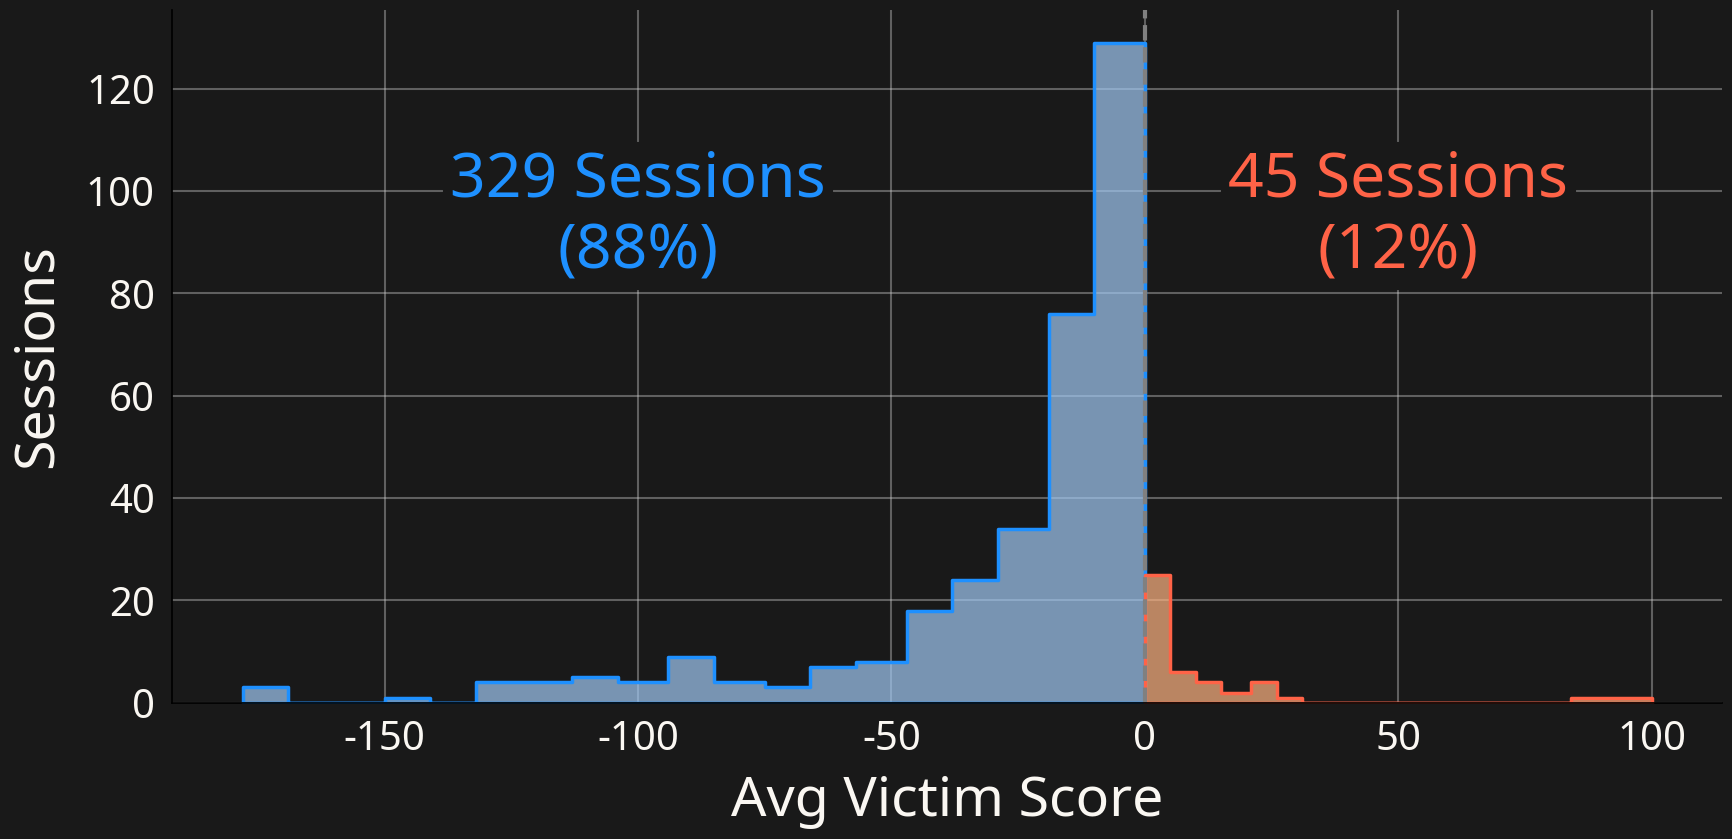

In [ ]:
## victim score histogram
y = session_scores_df.victims_score_w.dropna()
bins = np.concatenate([
    np.linspace(start=y.min(), stop=0, num=20, dtype=int),
    np.linspace(start=0, stop=y.max(), num=20, dtype=int)
])
bins

fig, ax = plt.subplots(figsize=(20, 9))
sns.histplot(
    session_scores_df,
    bins=np.unique(bins[: 20]),
    x='victims_score_w',
    edgecolor='dodgerblue',
    element='step',
    linewidth=2.5,
    alpha=0.7,
);
sns.histplot(
    session_scores_df,
    bins=np.unique(bins[20:]),
    x='victims_score_w',
    edgecolor='tomato',
    element='step',
    linewidth=2.5,
    alpha=0.7,
);

ax.axvline(x=0, linestyle='dashed', c='gray', lw=3);
ax.set_ylabel('Sessions', labelpad=15, fontsize=40);
ax.set_xlabel('Avg Victim Score', labelpad=10, fontsize=40);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for dir_ in ['bottom', 'left']:
    ax.spines[dir_].set_linewidth(1.25);
    ax.spines[dir_].set_color('black');

fractions = (
    session_scores_df
    .assign(
        pos_session=lambda df_: df_.victims_score_w >= 0,
    )
    .pos_session
    .value_counts(normalize=False)
    .to_dict()
)
n_ = sum(fractions.values())

ax.text(
    x=-100, y=85,
    s=f'{fractions[False]} Sessions\n({fractions[False] / n_:.0%})',
    c='dodgerblue',
    ha='center',
    backgroundcolor=NDBlue,
    fontsize=45,
);
ax.text(
    x=50, y=85,
    s=f'{fractions[True]} Sessions\n({fractions[True] / n_:.0%})',
    c='tomato',
    ha='center',
    backgroundcolor=NDBlue,
    fontsize=45,
);
ax.grid(alpha=0.4, );
plt.savefig(slides_path / 'vic_dist.pdf', bbox_inches='tight', transparent=True)

## bully score

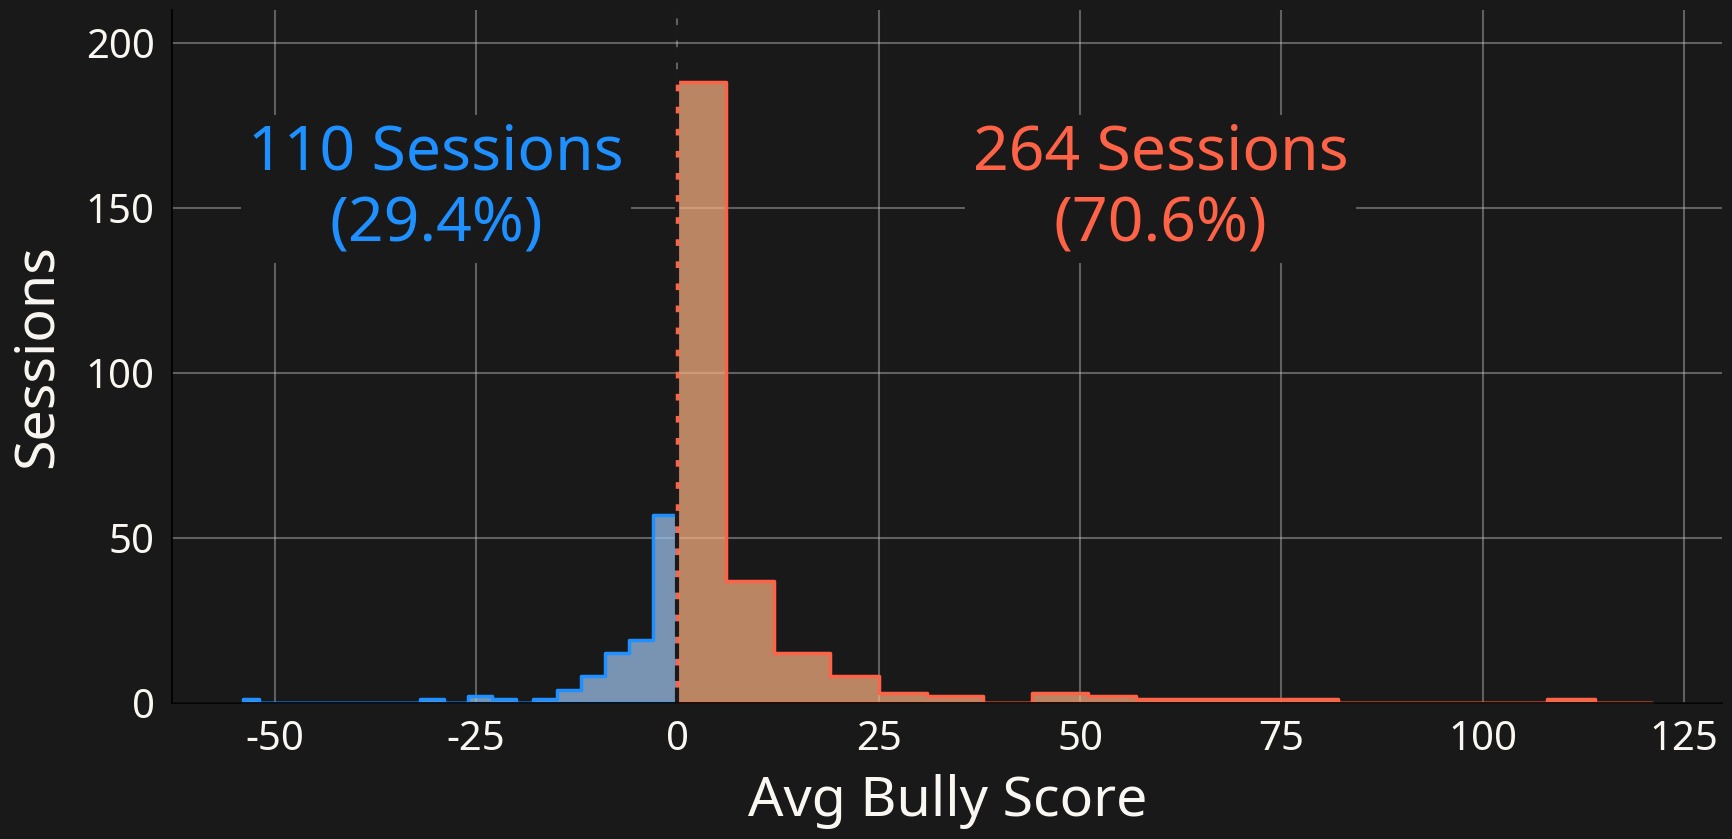

In [ ]:
data = session_scores_df.bully_score_w.dropna()

bins = np.concatenate([
    np.linspace(start=min(data), stop=0, num=20, dtype=int),
    np.linspace(start=0, stop=max(data), num=20, dtype=int)]
)

fig, ax = plt.subplots(figsize=(20, 9))

sns.histplot(
    bins=bins[: 20],
    x=data,
    edgecolor='dodgerblue',
    element='step',
    linewidth=2.5,
    alpha=0.7,
    ax=ax,
);
sns.histplot(
    session_scores_df,
    bins=bins[20:],
    x=data,
    edgecolor='tomato',
    element='step',
    linewidth=2.5,
    alpha=0.7,
    ax=ax,
);

ax.axvline(x=0, linestyle='dashed', c='k', lw=3);
# ax.set_xticks(bins);

ax.set_ylabel('Sessions', labelpad=15, fontsize=40);
ax.set_xlabel('Avg Bully Score', labelpad=10, fontsize=40);

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for dir_ in ['bottom', 'left']:
    ax.spines[dir_].set_linewidth(1.25);
    ax.spines[dir_].set_color('black');

fractions = (
    session_scores_df
    .assign(
        pos_session=lambda df_: df_.bully_score_w >= 0,
    )
    .pos_session
    .value_counts(normalize=False)
    .round(3)
    .to_dict()
)
n_ = sum(fractions.values())

ax.text(
    x=-30, y=140,
    s=f'{fractions[False]} Sessions\n({fractions[False] / n_:.1%})',
    c='dodgerblue',
    ha='center',
    backgroundcolor=NDBlue,
    fontsize=45,
);
ax.text(
    x=60, y=140,
    s=f'{fractions[True]} Sessions\n({fractions[True] / n_:.1%})',
    ha='center',
    c='tomato',
    backgroundcolor=NDBlue,
    fontsize=45,
);
ax.grid(alpha=0.4, );
ax.set_ylim([0, 210]);

plt.savefig(slides_path / 'bully_dist.pdf', bbox_inches='tight', transparent=True)

## quadrant plot

In [ ]:
x, y = 'bully_score_w', 'victims_score_w'

df = (
    session_scores_df
    .dropna(subset=[x, y])
    .assign(
        quadrant=lambda d: np.select(
            [
                (d[x] >= 0) & (d[y] >= 0),  # Quadrant I
                (d[x] < 0) & (d[y] >= 0),  # Quadrant II
                (d[x] < 0) & (d[y] < 0),  # Quadrant III
                (d[x] >= 0) & (d[y] < 0)  # Quadrant IV
            ],
            ['I', 'II', 'III', 'IV'],
            default='Axis'  # On one of the axes
        )
    )
)

display(df.head(2))
fractions = (
    df
    .quadrant
    .value_counts(normalize=False)
    .to_dict()
)
sum_ = sum(fractions.values())
display(fractions)

,session_id,num_nodes,num_edges,num_comments,main_victim,num_victims,num_agg_victims,num_bullies,num_defenders,num_agg_defenders,main_victim_in_deg,main_victim_weighted_in_deg,main_victim_out_deg,main_victim_weighted_out_deg,victim_avg_in_deg,victim_avg_weighted_in_deg,victim_avg_out_deg,victim_avg_weighted_out_deg,bully_avg_in_deg,bully_avg_weighted_in_deg,bully_avg_out_deg,bully_avg_weighted_out_deg,main_victim_score,main_victim_score_w,victims_score,victims_score_w,bully_score,bully_score_w,cyberbullying_comments,majority_topic,quadrant
0,649719813,11,10,41,Participants,3,0,3,5,5,3,3.5,3,4.0,1.0,1.166667,1.0,1.333333,1.333333,1.666667,1.0,1.166667,0,0.5,0.0,0.166667,-0.333333,-0.5,5,other,II
1,649719817,7,7,29,OP(lilbibby_),2,0,5,0,0,5,8.5,0,0.0,3.5,5.750000,0.0,0.000000,0.000000,0.000000,1.4,2.300000,-5,-8.5,-3.5,-5.750000,1.400000,2.3,5,other,IV


{'IV': 260, 'III': 69, 'II': 38, 'I': 4}

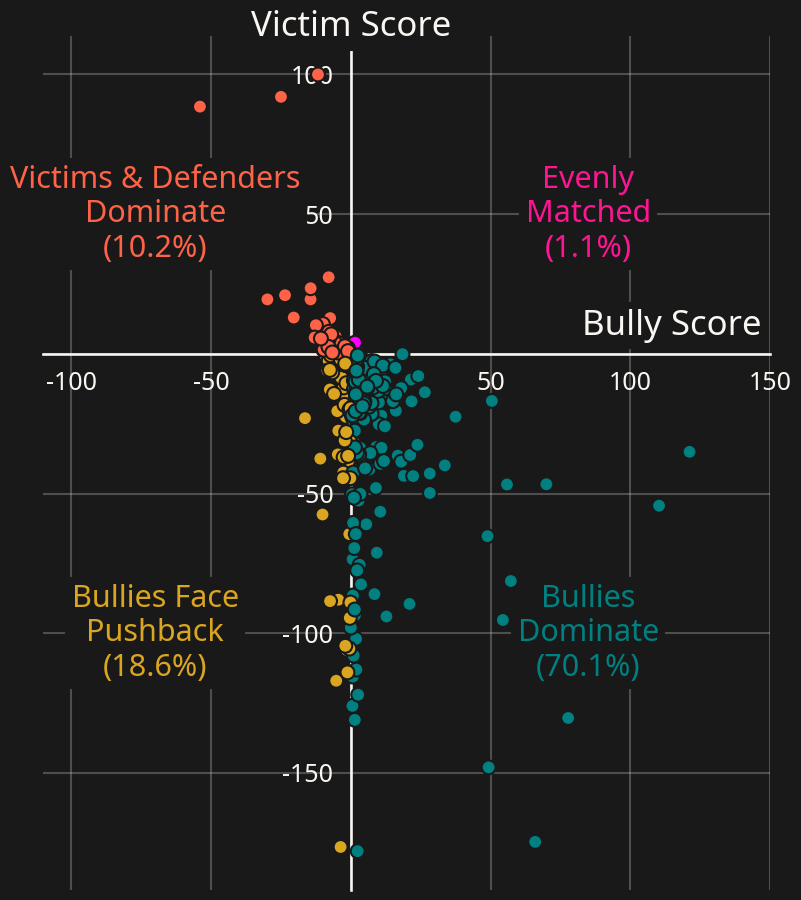

In [ ]:
fig, ax = plt.subplots(figsize=(22, 10), layout='tight');
# x, y = 'victim_score_w', 'bully_score_w'
x, y = 'bully_score_w', 'victims_score_w'

sns.scatterplot(
    data=df,
    x=x,
    y=y,
    edgecolors=NDBlue,
    hue=df.quadrant,
    palette={'I': 'magenta', 'II': 'tomato', 'III': 'goldenrod', 'IV': 'teal'},
    linewidth=1.5,
    s=100,
    alpha=1,
    ax=ax,
    zorder=10,
);

ax.set(
    ylabel='',
    xlabel='',
    # ylim=[None, 100],
    xlim=[-110, 150],
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for dir_ in ['bottom', 'left']:
    ax.spines[dir_].set_position('zero')
    ax.spines[dir_].set_color(palewhite)

ax.xaxis.set_label_coords(1.05, 0.65)  # (x, y) where x is from 0 (left) to 1 (right)
ax.yaxis.set_label_coords(-0.05, 1.)  # (x, y) where y is from 0 (bottom) to 1 (top)

ax.text(
    x=115, y=10,
    s='Bully Score',
    clip_on=False,
    fontsize=25,
    backgroundcolor=NDBlue,
    ha='center', va='center',
);
ax.text(
    x=0, y=117,
    s='Victim Score',
    clip_on=False,
    fontsize=25,
    backgroundcolor=NDBlue,
    ha='center', va='center',
);

## annotating the quadrants
ax.text(
    x=85, y=50,
    s=f'Evenly\nMatched\n({fractions["I"] / sum_:.1%})',
    fontsize=22,
    c='deeppink',
    clip_on=False,
    backgroundcolor=NDBlue,
    ha='center', va='center',
);

ax.text(
    x=-70, y=50,
    s=f'Victims & Defenders\nDominate\n({fractions["II"] / sum_:.1%})',
    fontsize=22,
    c='tomato',
    clip_on=False,
    backgroundcolor=NDBlue,
    ha='center', va='center',
);

ax.text(
    x=-70, y=-100,
    s=f'Bullies Face\nPushback\n({fractions["III"] / sum_:.1%})',
    fontsize=22,
    c='goldenrod',
    clip_on=False,
    backgroundcolor=NDBlue,
    ha='center', va='center',
);

ax.text(
    x=85, y=-100,
    s=f'Bullies\nDominate\n({fractions["IV"] / sum_:.1%})',
    fontsize=22,
    c='teal',
    clip_on=False,
    backgroundcolor=NDBlue,
    ha='center', va='center',
);

ax.set_aspect('equal')  # Equal aspect ratio
ax.tick_params(axis='both', labelsize=18)

# fig.subplots_adjust(right=0.1, left=0.1)  # Increase margins
ax.legend().set_visible(False)
ax.grid(alpha=0.3, zorder=0);

plt.savefig(slides_path / 'joint_dist.pdf', bbox_inches='tight', transparent=True)

# topic wise splits

In [ ]:
majority_topic_d = (
    session_scores_df
    .dropna(subset=['bully_score_w'])
    .majority_topic
    .value_counts()
    [: 5]
    .to_dict()
)

sum_ = session_scores_df.dropna(subset=['bully_score_w']).session_id.nunique()

majority_topic_d = {k: f'{k.title().replace("_", " ")}\n({v / sum_:.1%})' for k, v in majority_topic_d.items()}
display(majority_topic_d)

majority_topic_df = (
    session_scores_df
    .dropna(subset=['bully_score_w'])
    .query('majority_topic.isin(@majority_topic_d)')
)
display(majority_topic_df)

{'other': 'Other\n(50.1%)',
 'physical': 'Physical\n(9.4%)',
 'gender': 'Gender\n(7.0%)',
 'intellectual': 'Intellectual\n(6.2%)',
 'social_status': 'Social Status\n(5.9%)'}

,session_id,num_nodes,num_edges,num_comments,main_victim,num_victims,num_agg_victims,num_bullies,num_defenders,num_agg_defenders,main_victim_in_deg,main_victim_weighted_in_deg,main_victim_out_deg,main_victim_weighted_out_deg,victim_avg_in_deg,victim_avg_weighted_in_deg,victim_avg_out_deg,victim_avg_weighted_out_deg,bully_avg_in_deg,bully_avg_weighted_in_deg,bully_avg_out_deg,bully_avg_weighted_out_deg,main_victim_score,main_victim_score_w,victims_score,victims_score_w,bully_score,bully_score_w,cyberbullying_comments,majority_topic
0,649719813,11,10,41,Participants,3,0,3,5,5,3,3.5,3,4.0,1.000000,1.166667,1.000000,1.333333,1.333333,1.666667,1.000000,1.166667,0,0.5,0.000000,0.166667,-0.333333,-0.500000,5,other
1,649719817,7,7,29,OP(lilbibby_),2,0,5,0,0,5,8.5,0,0.0,3.500000,5.750000,0.000000,0.000000,0.000000,0.000000,1.400000,2.300000,-5,-8.5,-3.500000,-5.750000,1.400000,2.300000,5,other
2,649719818,30,137,114,OP(catdagreat),10,3,18,2,2,18,22.5,2,2.5,7.900000,9.450000,4.500000,22.250000,2.777778,12.638889,4.388889,5.250000,-16,-20.0,-3.400000,12.800000,1.611111,-7.388889,44,physical
3,649719821,2,1,140,Participants,1,0,1,0,0,1,2.0,0,0.0,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,-1,-2.0,-1.000000,-2.000000,1.000000,2.000000,1,other
4,649719823,7,10,41,Participants,3,0,4,0,0,4,22.0,0,0.0,3.333333,15.333333,0.000000,0.000000,0.000000,0.000000,2.500000,11.500000,-4,-22.0,-3.333333,-15.333333,2.500000,11.500000,16,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,649719795,11,21,33,Participants,2,1,1,8,8,1,14.0,6,7.0,1.000000,13.000000,6.000000,8.000000,8.000000,10.000000,2.000000,26.000000,5,-7.0,5.000000,-5.000000,-6.000000,16.000000,11,intellectual
369,649719796,16,37,115,Participants,6,0,3,7,7,3,103.5,4,6.0,1.500000,57.666667,2.666667,3.333333,4.000000,5.000000,3.000000,115.333333,1,-97.5,1.166667,-54.333333,-1.000000,110.333333,55,other
370,649719797,21,83,121,Participants,4,2,16,1,1,16,51.5,1,1.0,11.750000,33.250000,6.000000,14.500000,2.000000,4.125000,2.937500,8.312500,-15,-50.5,-5.750000,-18.750000,0.937500,4.187500,54,intellectual
371,649719798,5,4,18,Participants,1,0,1,3,3,1,6.0,0,0.0,1.000000,6.000000,0.000000,0.000000,3.000000,4.000000,1.000000,6.000000,-1,-6.0,-1.000000,-6.000000,-2.000000,2.000000,4,gender


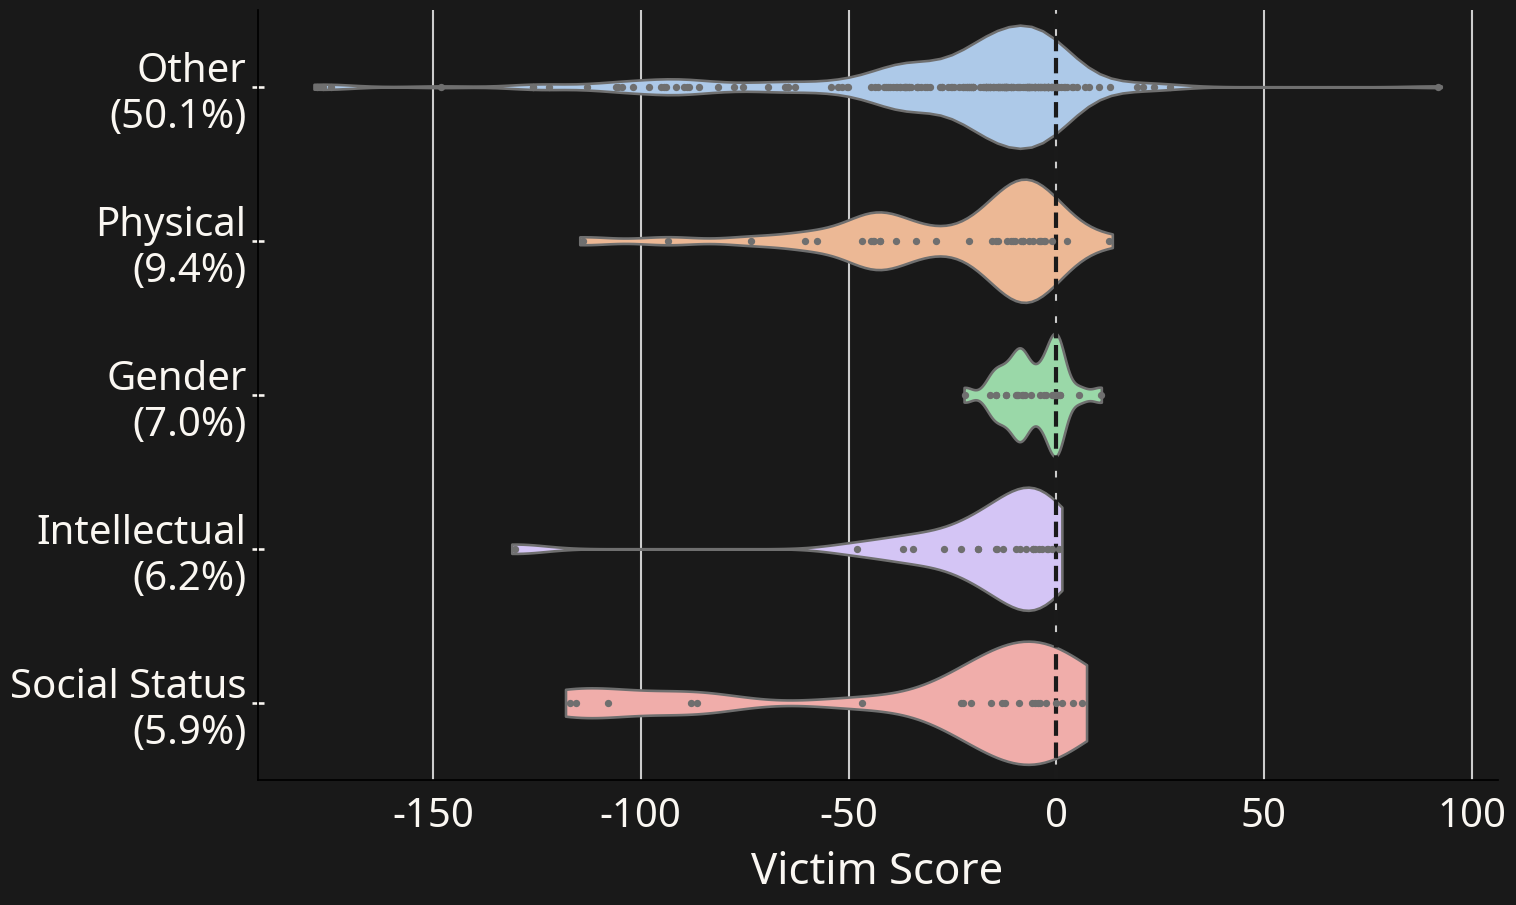

In [ ]:


fig, ax = plt.subplots(figsize=(16, 10))

sns.violinplot(
    majority_topic_df,
    x='victims_score_w',
    y='majority_topic',
    hue='majority_topic',
    order=list(majority_topic_d.keys()),
    ax=ax,
    inner='point',
    cut=0.1,
    bw_adjust=0.5,
    saturation=0.7,
);

ax.axvline(x=0, linestyle='dashed', c='k', lw=3);

ax.set_yticks(ax.get_yticks(), majority_topic_d.values());

ax.set_ylabel('', labelpad=15);
ax.set_xlabel('Victim Score', labelpad=10);
ax.tick_params(axis='y', which='major', direction='inout', left=True, labelleft=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for dir_ in ['bottom', 'left']:
    ax.spines[dir_].set_linewidth(1.25);
    ax.spines[dir_].set_color('black');
# ax.legend().set_visible(False);

In [ ]:
majority_topic_df

,session_id,num_nodes,num_edges,num_comments,main_victim,num_victims,num_agg_victims,num_bullies,num_defenders,num_agg_defenders,main_victim_in_deg,main_victim_weighted_in_deg,main_victim_out_deg,main_victim_weighted_out_deg,victim_avg_in_deg,victim_avg_weighted_in_deg,victim_avg_out_deg,victim_avg_weighted_out_deg,bully_avg_in_deg,bully_avg_weighted_in_deg,bully_avg_out_deg,bully_avg_weighted_out_deg,main_victim_score,main_victim_score_w,victims_score,victims_score_w,bully_score,bully_score_w,cyberbullying_comments,majority_topic
0,649719813,11,10,41,Participants,3,0,3,5,5,3,3.5,3,4.0,1.000000,1.166667,1.000000,1.333333,1.333333,1.666667,1.000000,1.166667,0,0.5,0.000000,0.166667,-0.333333,-0.500000,5,other
1,649719817,7,7,29,OP(lilbibby_),2,0,5,0,0,5,8.5,0,0.0,3.500000,5.750000,0.000000,0.000000,0.000000,0.000000,1.400000,2.300000,-5,-8.5,-3.500000,-5.750000,1.400000,2.300000,5,other
2,649719818,30,137,114,OP(catdagreat),10,3,18,2,2,18,22.5,2,2.5,7.900000,9.450000,4.500000,22.250000,2.777778,12.638889,4.388889,5.250000,-16,-20.0,-3.400000,12.800000,1.611111,-7.388889,44,physical
3,649719821,2,1,140,Participants,1,0,1,0,0,1,2.0,0,0.0,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,-1,-2.0,-1.000000,-2.000000,1.000000,2.000000,1,other
4,649719823,7,10,41,Participants,3,0,4,0,0,4,22.0,0,0.0,3.333333,15.333333,0.000000,0.000000,0.000000,0.000000,2.500000,11.500000,-4,-22.0,-3.333333,-15.333333,2.500000,11.500000,16,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,649719795,11,21,33,Participants,2,1,1,8,8,1,14.0,6,7.0,1.000000,13.000000,6.000000,8.000000,8.000000,10.000000,2.000000,26.000000,5,-7.0,5.000000,-5.000000,-6.000000,16.000000,11,intellectual
369,649719796,16,37,115,Participants,6,0,3,7,7,3,103.5,4,6.0,1.500000,57.666667,2.666667,3.333333,4.000000,5.000000,3.000000,115.333333,1,-97.5,1.166667,-54.333333,-1.000000,110.333333,55,other
370,649719797,21,83,121,Participants,4,2,16,1,1,16,51.5,1,1.0,11.750000,33.250000,6.000000,14.500000,2.000000,4.125000,2.937500,8.312500,-15,-50.5,-5.750000,-18.750000,0.937500,4.187500,54,intellectual
371,649719798,5,4,18,Participants,1,0,1,3,3,1,6.0,0,0.0,1.000000,6.000000,0.000000,0.000000,3.000000,4.000000,1.000000,6.000000,-1,-6.0,-1.000000,-6.000000,-2.000000,2.000000,4,gender


In [ ]:
topic_agg_df = (
    majority_topic_df
    .assign(
        agg_def_victims=lambda df_: df_.num_agg_victims + df_.num_agg_defenders,
    )
    .groupby('majority_topic', as_index=False)
    .agg(
        num_sessions=('session_id', 'nunique'),
        mean_bullies=('num_bullies', 'mean'),
        mean_bully_w_out=('bully_avg_weighted_out_deg', 'mean'),
        mean_bully_w_in=('bully_avg_weighted_in_deg', 'mean'),
        mean_victim_w_out=('victim_avg_weighted_out_deg', 'mean'),
        mean_victim_w_in=('victim_avg_weighted_in_deg', 'mean'),
    )
    .sort_values(by='num_sessions', ascending=False)
)
display(topic_agg_df)

,majority_topic,num_sessions,mean_bullies,mean_bully_w_out,mean_bully_w_in,mean_victim_w_out,mean_victim_w_in
2,other,186,16.139785,8.633167,3.526121,5.908564,33.831480
3,physical,35,20.342857,5.352673,2.519929,4.033571,30.100238
0,gender,26,5.153846,3.961265,4.432293,4.871795,10.312179
1,intellectual,23,9.347826,10.666753,4.430366,6.905072,25.733696
4,social_status,22,19.045455,6.482115,3.649197,5.048701,36.317100


## in & out degrees

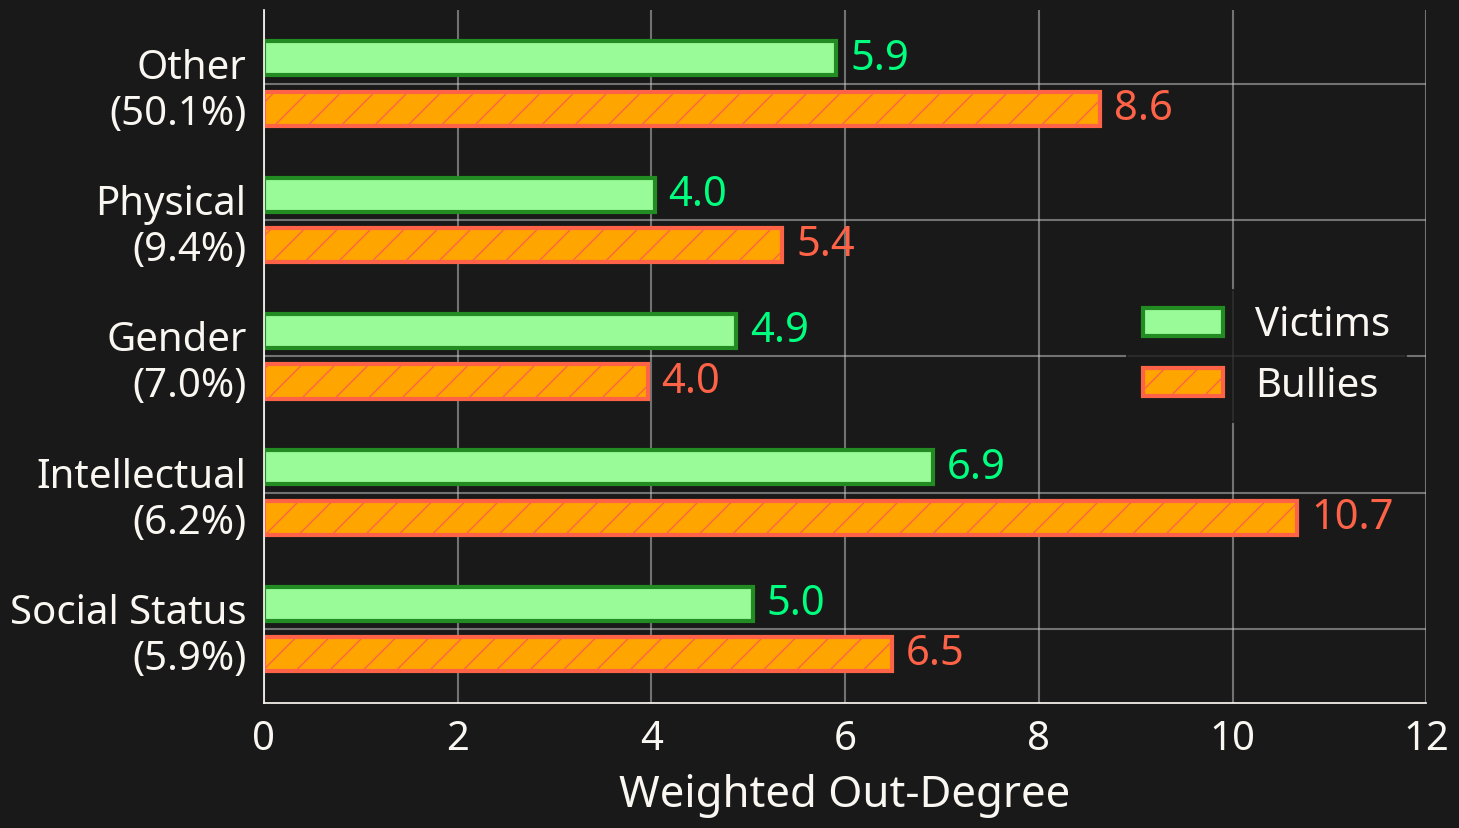

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))

categories = topic_agg_df.majority_topic.tolist()
group1 = topic_agg_df.mean_victim_w_out
group2 = topic_agg_df.mean_bully_w_out

x = np.arange(topic_agg_df.majority_topic.nunique())  # [0, 1, 2]
width = 0.25  # Width of each bar

# Plot side-by-side bars
bars1 = ax.barh(
    x - width / 1.35, group1, width,
    edgecolor='forestgreen', lw=3, label='Victims',
    facecolor='palegreen',
)
bars2 = ax.barh(
    x + width / 1.35, group2, width,
    edgecolor='tomato', lw=3, label='Bullies',
    facecolor='Orange', hatch='/',
)

ax.bar_label(bars1, fmt='%.1f', c='SpringGreen', padding=10, fontsize=30)
ax.bar_label(bars2, fmt='%.1f', c='tomato', padding=10, fontsize=30)

# Custom x-axis labels
ax.set_yticks(x)
ax.set_yticklabels(majority_topic_d.values());

ax.set_xlim([0, 12])
ax.set_xlabel('Weighted Out-Degree', labelpad=10)
# ax.set_title('Weighted Out-degree')
ax.legend(ncol=1, facecolor=NDBlue, edgecolor=NDBlue, loc='center right');

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for dir_ in ['bottom', 'left']:
    ax.spines[dir_].set_linewidth(1.25);
    ax.spines[dir_].set_color(palewhite);

# ax.legend().set_visible(False);
ax.invert_yaxis()
# ax.set_yticklabels([])
# ax.set_ylabel('Weighted In')
ax.grid(alpha=0.5)
plt.savefig(slides_path / 'out-degree.pdf', bbox_inches='tight', transparent=True)

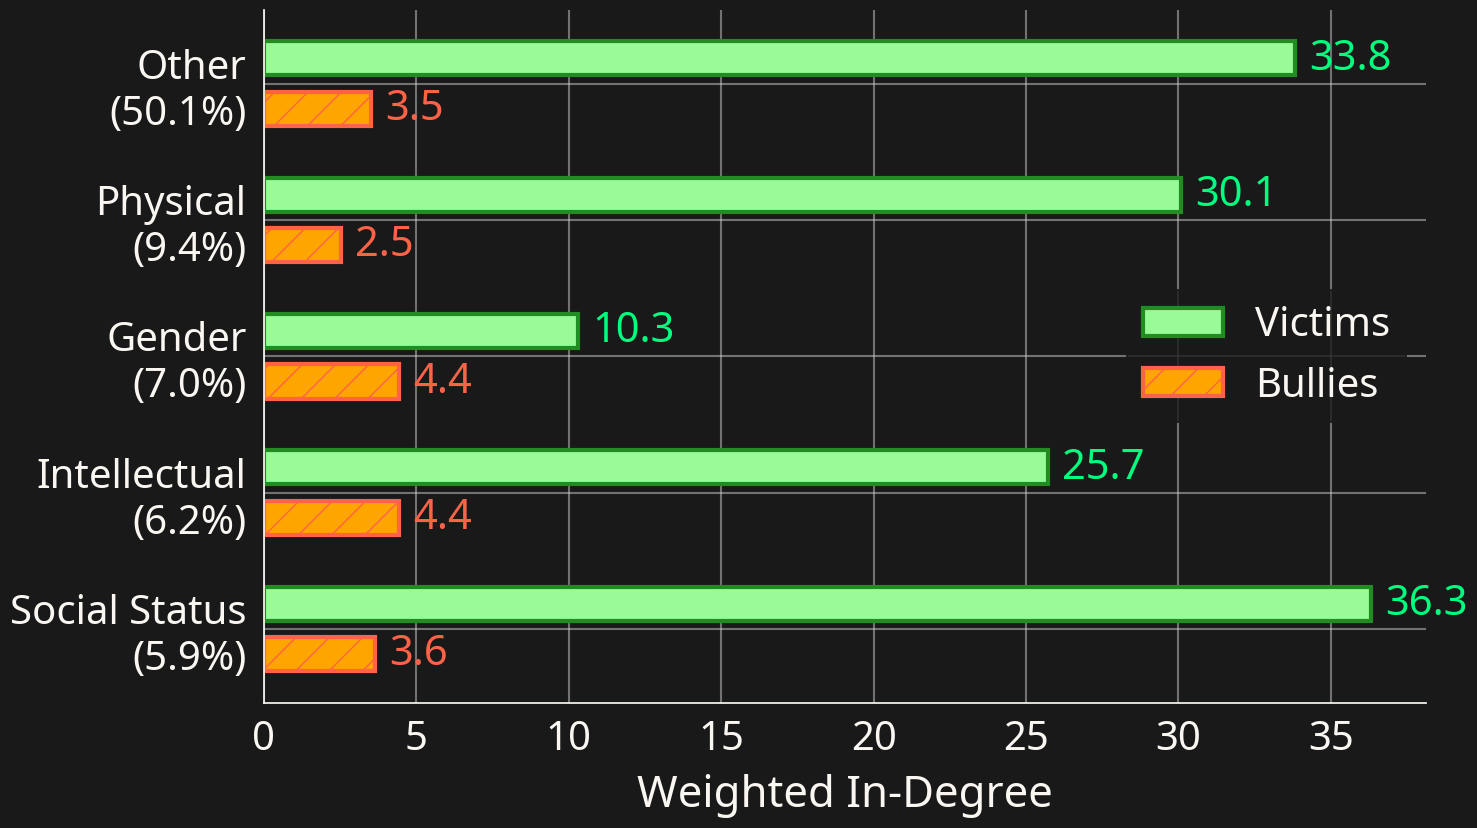

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))

categories = topic_agg_df.majority_topic.tolist()
group1 = topic_agg_df.mean_victim_w_in
group2 = topic_agg_df.mean_bully_w_in

x = np.arange(topic_agg_df.majority_topic.nunique())  # [0, 1, 2]
width = 0.25  # Width of each bar

# Plot side-by-side bars
bars1 = ax.barh(
    x - width / 1.35, group1, width,
    edgecolor='forestgreen', lw=3, label='Victims',
    facecolor='palegreen',
)
bars2 = ax.barh(
    x + width / 1.35, group2, width,
    edgecolor='tomato', lw=3, label='Bullies',
    facecolor='Orange', hatch='/',
)

ax.bar_label(bars1, fmt='%.1f', c='SpringGreen', padding=10, fontsize=30)
ax.bar_label(bars2, fmt='%.1f', c='tomato', padding=10, fontsize=30)

# Custom x-axis labels
ax.set_yticks(x)
ax.set_yticklabels(majority_topic_d.values());

# ax.set_xlim([0, 25])
ax.set_xlabel('Weighted In-Degree', labelpad=10)
# ax.set_title('Weighted in-degree plot')
ax.legend(ncol=1, facecolor=NDBlue, edgecolor=NDBlue, loc='best');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for dir_ in ['bottom', 'left']:
    ax.spines[dir_].set_linewidth(1.25);
    ax.spines[dir_].set_color(palewhite);
# ax.legend().set_visible(False)
ax.invert_yaxis()
ax.grid(alpha=0.5)

plt.savefig(slides_path / 'in-degree.pdf', bbox_inches='tight', transparent=True)

In [ ]:
topic_agg_df

,majority_topic,num_sessions,mean_bullies,mean_bully_w_out,mean_bully_w_in,mean_victim_w_out,mean_victim_w_in
2,other,186,16.139785,8.633167,3.526121,5.908564,33.831480
3,physical,35,20.342857,5.352673,2.519929,4.033571,30.100238
0,gender,26,5.153846,3.961265,4.432293,4.871795,10.312179
1,intellectual,23,9.347826,10.666753,4.430366,6.905072,25.733696
4,social_status,22,19.045455,6.482115,3.649197,5.048701,36.317100


In [ ]:
(
    topic_agg_df
    .sort_values(by='num_sessions', ascending=False)
    .assign(
        perc_sessions=lambda df_: df_.num_sessions / df_.num_sessions.sum() * 100,
    )
    [['majority_topic', 'num_sessions', 'perc_sessions']]
)

,majority_topic,num_sessions,perc_sessions
2,other,186,63.698630
3,physical,35,11.986301
0,gender,26,8.904110
1,intellectual,23,7.876712
4,social_status,22,7.534247


In [ ]:
s = {652910845}
(
    df
    .query('num_nodes<10 & num_defenders>1 & num_bullies>1')
)

,session_id,num_nodes,num_edges,num_comments,main_victim,num_victims,num_agg_victims,num_bullies,num_defenders,num_agg_defenders,main_victim_in_deg,main_victim_weighted_in_deg,main_victim_out_deg,main_victim_weighted_out_deg,victim_avg_in_deg,victim_avg_weighted_in_deg,victim_avg_out_deg,victim_avg_weighted_out_deg,bully_avg_in_deg,bully_avg_weighted_in_deg,bully_avg_out_deg,bully_avg_weighted_out_deg,main_victim_score,main_victim_score_w,victims_score,victims_score_w,bully_score,bully_score_w,cyberbullying_comments,majority_topic,quadrant
60,649719934,8,12,14,NaN,1,0,3,4,4,3,4.0,3,4.0,3.000000,4.000000,3.000000,4.000000,2.000000,2.666667,1.000000,1.333333,0,0.0,0.00,0.000000,-1.000000,-1.333333,6,other,II
103,649720017,9,21,37,Participants,3,0,3,3,3,3,23.0,3,8.0,2.333333,14.500000,2.333333,5.333333,2.333333,6.000000,2.333333,14.500000,0,-15.0,0.00,-9.166667,0.000000,8.500000,20,social_status|intellectual,IV
127,652910845,9,9,33,OP(nigelsylvester),1,0,2,6,6,2,5.0,6,9.0,2.000000,5.000000,6.000000,9.000000,0.500000,1.000000,1.000000,2.500000,4,4.0,4.00,4.000000,0.500000,1.500000,5,social_status,I
145,679604608,5,4,132,Participants,1,0,2,2,2,2,4.5,2,3.0,2.000000,4.500000,2.000000,3.000000,0.000000,0.000000,1.000000,2.250000,0,-1.5,0.00,-1.500000,1.000000,2.250000,4,gender|physical|other|sexual|other,IV
176,679604947,5,5,46,Participants,1,0,2,2,2,2,7.5,1,2.0,2.000000,7.500000,1.000000,2.000000,1.000000,1.500000,1.000000,3.750000,-1,-5.5,-1.00,-5.500000,0.000000,2.250000,8,intellectual,IV
182,679604977,9,13,81,Participants,1,0,5,3,3,5,17.0,1,1.0,5.000000,17.000000,1.000000,1.000000,1.400000,1.400000,1.000000,3.400000,-4,-16.0,-4.00,-16.000000,-0.400000,2.000000,11,physical|other,IV
194,679605067,9,22,77,OP(iwearsin),1,0,4,4,4,4,5.0,2,7.5,4.000000,5.000000,2.000000,7.500000,4.000000,10.500000,1.000000,1.250000,-2,2.5,-2.00,2.500000,-3.000000,-9.250000,8,physical,II
197,679605109,6,8,81,Participants,1,0,3,2,2,3,8.0,2,2.0,3.000000,8.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.666667,-1,-6.0,-1.00,-6.000000,0.000000,1.666667,9,social_status|race,IV
208,652903333,6,9,15,Participants,1,0,2,3,3,2,11.5,3,6.0,2.000000,11.500000,3.000000,6.000000,2.000000,4.500000,1.000000,5.750000,1,-5.5,1.00,-5.500000,-1.000000,1.250000,10,social_status|other|other,IV
244,652903446,9,22,29,Participants,4,1,3,2,2,3,22.5,2,3.0,3.000000,15.500000,2.000000,3.250000,1.333333,2.666667,4.000000,20.666667,-1,-19.5,-1.00,-12.250000,2.666667,18.000000,26,social_status,IV


![CleanShot 2025-05-08 at 14.21.09@2x.png](attachment:7ffb4ebf-69e3-4a93-8c3b-2b2aaeaba7cf.png)

In [ ]:
import textwrap

In [ ]:
vals = {
    'At least one type of cyberbullying': 46,
    'Offensive name-calling': 32,
    'Spreading of false rumors about them': 22,
    'Receiving unsolicited explicit images': 17,
    "Constantly being asked their whereabouts by someone not their parent": 15,
    'Physical threats': 10,
    'Having explicit images of them shared without consent': 7
}
# wrap each at, say, 15 characters, joining with newline
wrapped = [
    "\n".join(textwrap.wrap(label, width=28))
    for label in vals.keys()
]

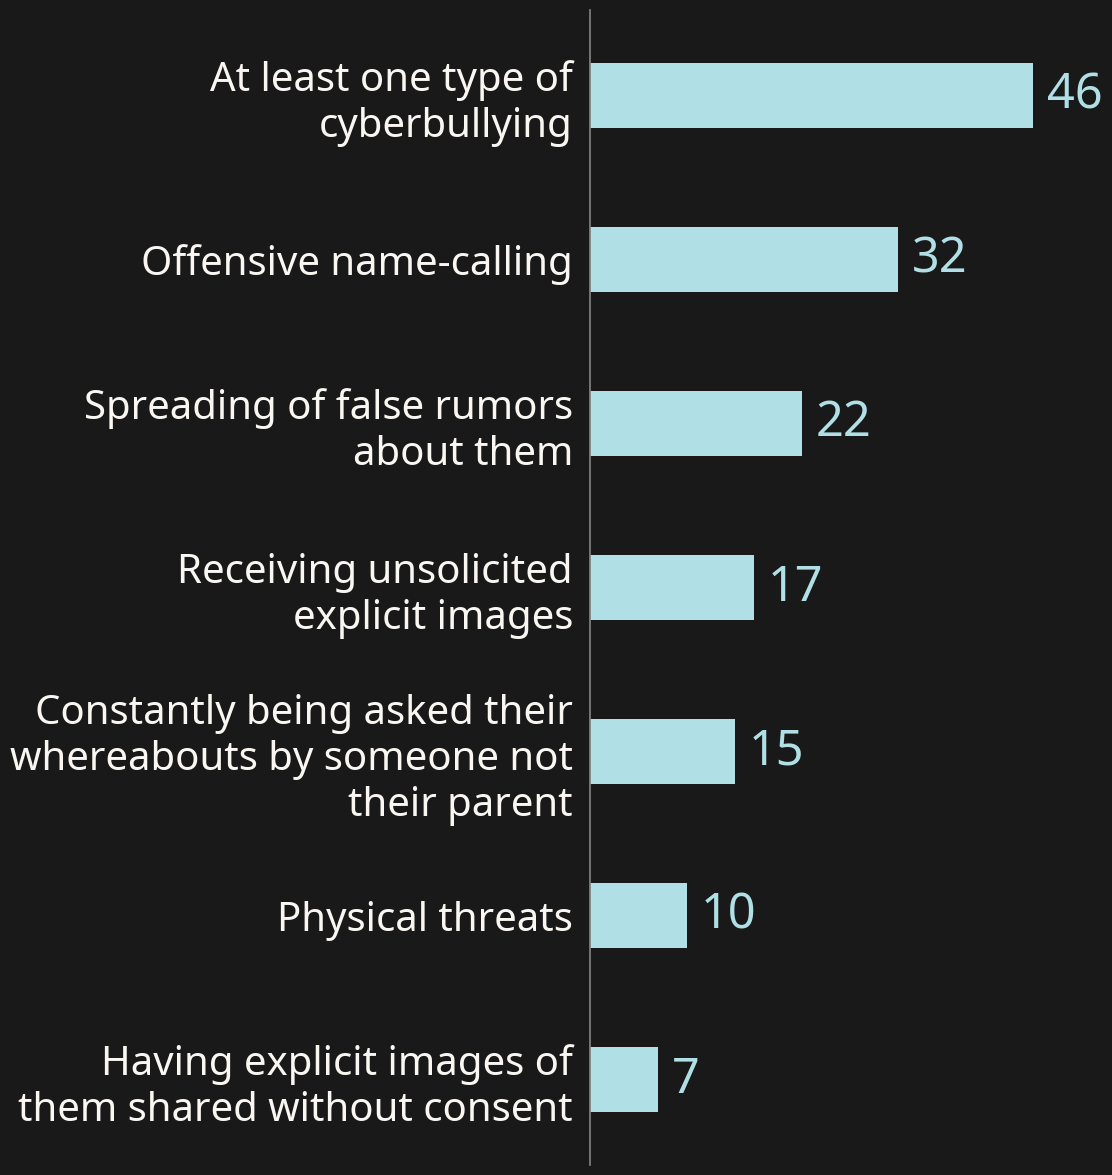

In [ ]:
fig, ax = plt.subplots(figsize=(6, 15))

x = np.arange(7)  # [0, 1, 2]
width = 0.40  # Width of each bar

# Plot side-by-side bars
bars1 = ax.barh(
    x, list(vals.values()), width,
    edgecolor='forestgreen', lw=0,
    facecolor='powderblue',
)

ax.bar_label(bars1, fmt='%d', c='powderblue', padding=10, fontsize=35)

# Custom x-axis labels
ax.set_yticks(x)
ax.set_yticklabels(wrapped);

# ax.set_xlim([0, 25])
# ax.set_xlabel('Weighted In-Degree', labelpad=10)
# ax.set_title('Weighted in-degree plot')
# ax.legend(ncol=1, facecolor=NDBlue, edgecolor=NDBlue, loc='best');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for dir_ in ['bottom', 'left']:
    ax.spines[dir_].set_linewidth(1.25);
    ax.spines[dir_].set_color('gray');

# ax.legend().set_visible(False)
ax.set_xticklabels([]);
ax.spines['bottom'].set_visible(False)
ax.invert_yaxis()
ax.grid(alpha=0)

plt.savefig(slides_path / 'cyberstats.pdf', bbox_inches='tight', transparent=True)